## Data preprocessing and exploration

In [6]:
import sys
import time
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input
from sklearn.model_selection import KFold

np.set_printoptions(threshold=1000)

# load data from npz files
training_file = "file:///C:/Users/Irisa/Desktop/Uni/DA2/sets/train.npz"
FinalTEST = "file:///C:/Users/Irisa/Desktop/Uni/DA2/sets/final_test.npz"

path_1 = tf.keras.utils.get_file('train.npz', training_file)
path_10 = tf.keras.utils.get_file('final_test.npz', FinalTEST)

In [3]:
with np.load(path_1) as data:
    train_examples_bands = data['bands']
    train_labels_lulc = data['lulc']
    
classNumbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

train_labels_bands_1 = train_examples_bands
train_labels_lulc_1 = train_labels_lulc
train_examples_bands = np.reshape(train_examples_bands, (-1, 33, 33, 6))

In [ ]:
print(train_examples_bands.shape)
print(train_labels_bands_1.shape)
print(train_labels_lulc_1.shape)

In [ ]:
# Name of keys
print("Name of keys are:", data.files)

In [ ]:
# frequency of classes
(unique, counts) = np.unique(train_labels_lulc, return_counts=True)
classFrequencies = np.asarray((unique, counts)).T
print("Frequencies of classes are:")
print(classFrequencies)


In [6]:
print(train_labels_bands_1.shape)
np.save('train_labels_bands_no00s', train_labels_bands_1)
np.save('train_labels_lulc_no00s', train_labels_lulc_1)

(8693, 12, 33, 33, 6)


######  Plotting an image chanels

In [ ]:
img = train_examples_bands[1,32]

plt.imshow(img, cmap="gray")

###### Exploratory visualization of the dataset

In [ ]:
%matplotlib inline

classDictionary = {}

for x in set(train_labels_lulc):    
    classDictionary[x] = (train_labels_lulc == x).sum()   

key = [*classDictionary.keys()]
value = [*classDictionary.values()]

plt.figure(figsize=(25,5))
plt.bar(key, value, align='center', alpha=.5)
plt.xticks(key, key)
plt.ylabel('Count')
plt.title('Classes and their respective frequencies') 
plt.show()

## Model creating

In [2]:
IMAGE_SIZE = 33
CHANNELS = 6

def puremodel():

    model = models.Sequential()

    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(layers.Dropout(0.5))    
    
    model.add(layers.Conv2D(192, (3, 3), padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(192, (1, 1),padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(11, (1, 1), padding='valid'))

    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Activation('softmax'))
    model.summary()
    
    return model

In [8]:
model = puremodel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 192)       3

## Training our model

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_examples_bands, 
                                                    np.repeat(train_labels_lulc, 12), 
                                                    test_size=0.3)


In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_improved.h5', 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only= True, 
                             mode='auto')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size=150, epochs = 30, 
                    validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/30
560/560 [==============================] - 68s 115ms/step - loss: 1.3216 - accuracy: 0.5788 - val_loss: 1.2478 - val_accuracy: 0.5869
Epoch 2/30
560/560 [==============================] - 65s 116ms/step - loss: 1.2355 - accuracy: 0.5920 - val_loss: 1.2472 - val_accuracy: 0.5842
Epoch 3/30
560/560 [==============================] - 65s 116ms/step - loss: 1.2161 - accuracy: 0.5972 - val_loss: 1.2013 - val_accuracy: 0.5971
Epoch 4/30
560/560 [==============================] - 80s 142ms/step - loss: 1.1957 - accuracy: 0.6008 - val_loss: 1.1744 - val_accuracy: 0.6012
Epoch 5/30
560/560 [==============================] - 65s 117ms/step - loss: 1.1765 - accuracy: 0.6050 - val_loss: 1.1713 - val_accuracy: 0.6060
Epoch 6/30
560/560 [==============================] - 65s 116ms/step - loss: 1.1536 - accuracy: 0.6113 - val_loss: 1.1426 - val_accuracy: 0.6152
Epoch 7/30
560/560 [==============================] - 65s 116ms/step - loss: 1.1302 - accuracy: 0.6176 - val_loss: 1.1134 - val_ac

1125/1125 - 8s - loss: 0.9605 - accuracy: 0.6784
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


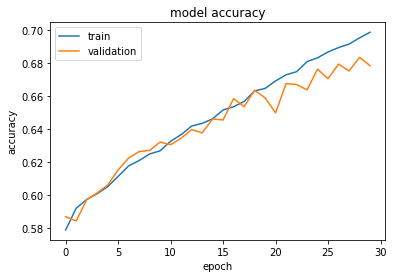

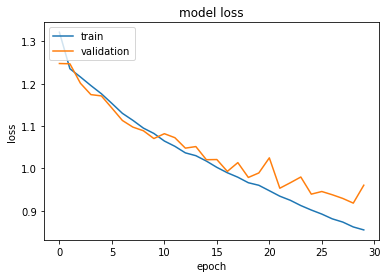

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Modifying the original dataset

### Extracting the arrays that contains only 'No DATA' class inctancies and that don't have any of class 0 both for bands and lulc sets

In [ ]:
print(train_labels_lulc[1:201])

rows_to_delete = []
zeros_bands = np.empty([1307,12,33,33,6])
zeros_labl = np.empty([15684])
zero_image = []

for i in range(10000):
    if train_labels_lulc[i] == 0:
        j = 0
        j = j +i
        rows_to_delete.append(j)

print("initial array", str(rows_to_delete))
  
# printing type of ini_array
print("type of ini_array", type(rows_to_delete))
  
# using shortcut method to reverse
res_rows_to_delete = rows_to_delete[::-1]
  
# printing result
print("final array", str(res_rows_to_delete))

#creating arrays with only "No DATA" class instancies/ids
for i in range (0,1307):
    if i == 0:
        a = 0
        a = res_rows_to_delete[i] - 1
        zeros_bands[i] = train_labels_bands_1[a]
    else:
        a = 0
        a = res_rows_to_delete[i]
        zeros_bands[i] = train_labels_bands_1[a]

#deleting all the instancies/ids of "No DATA" class
for i in range (0,1307):
    if i == 0:
        train_labels_bands_1 = np.delete(train_labels_bands_1, (res_rows_to_delete[i] - 1), axis=0)
        train_labels_lulc_1 =n p.delete(train_labels_lulc_1, (res_rows_to_delete[i] - 1), axis=0)
    else:
        train_labels_bands_1 = np.delete(train_labels_bands_1, (res_rows_to_delete[i]), axis=0)
        train_labels_lulc_1 = np.delete(train_labels_lulc_1, (res_rows_to_delete[i]), axis=0)


print(rows_to_delete)
print(train_labels_bands_1.shape)
print(train_labels_lulc_1.shape)

zero_bands = np.reshape(zero_bands, (-1, 33, 33, 6))

### Augmenting the sets containing no "NO Data" class records

In [10]:
train_labels_bands_1 = np.reshape(train_labels_bands_1, (-1, 33, 33, 6))
print (train_labels_bands_1.shape)

number = 0
id_zeros = []
Image_set1 = []
Image_set2 = []

#Find out inumber of cell(s) with zero value
for i in range(104316):
    if (train_labels_bands_1[i].max() - train_labels_bands_1[i].min()) == 0:
        number = number + 1
        
print (number)

#Finding indexes of this cells
for i in range(104316):
    if (train_labels_bands_1[i].max() - train_labels_bands_1[i].min()) == 0:
        indexx = i 
        id_zeros.append(indexx)

id_zeros = np.array(id_zeros)
print (id_zeros.size)

#Changing zero values  to process the augmentaion algorithm correctly
for i in range(id_zeros.size):
    train_labels_bands_1[id_zeros[i],1,1,1] = 0.01


#Splitting data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_labels_bands_1, np.repeat(train_labels_lulc_1, 12), test_size=0.25)

#Working on augmentation
for i in range(78237):
    image1 = np.array(X_train[i])
    
    #print(X_test.shape)

    seq1 = iaa.Sequential([
        iaa.Fliplr(0.56), # horizontal flips
        iaa.Flipud(0.46), # vertical flips
        iaa.Sometimes(
            0.50, 
            iaa.OneOf([
                iaa.Affine(rotate=90), 
                iaa.Affine(rotate=-90)])
        )
       
    ], random_order=True)

    # Augment images.
    image_aug1 = seq(image=image1)
    
    npimage_aug1 = np.array(image_aug1)
    Image_set1.append(npimage_aug1)

XX_train = np.array(Image_set1)

for i in range(26079):
    image2 = np.array(X_test[i])
    
    seq2 = iaa.Sequential([
       
    ], random_order=True)
    
    image_aug2 = seq2(image=image2)
    
    npimage_aug2 = np.array(image_aug2)
    Image_set2.append(npimage_aug2)

XX_test = np.array(Image_set2)

y_trainarr = np.array(y_train)
y_testarr = np.array(y_test)

(78237, 33, 33, 6)
2 , 2
--------------------------------
2 , 2
////////////////////////////////
9 , 8
--------------------------------
9 , 8
////////////////////////////////
[[[0.2157 0.1744 0.1666 0.1751 0.1632 0.12  ]
  [0.217  0.1736 0.1665 0.1784 0.1632 0.12  ]
  [0.2151 0.1722 0.1639 0.1755 0.1692 0.1266]
  ...
  [0.2924 0.2369 0.2246 0.264  0.2376 0.1954]
  [0.2954 0.2395 0.2325 0.2623 0.2376 0.1954]
  [0.2911 0.2384 0.2519 0.2605 0.2632 0.2159]]

 [[0.2193 0.177  0.1717 0.1819 0.1632 0.12  ]
  [0.2212 0.1782 0.1701 0.1813 0.1632 0.12  ]
  [0.2216 0.1758 0.1668 0.1811 0.1692 0.1266]
  ...
  [0.2678 0.2181 0.2113 0.2412 0.2376 0.1954]
  [0.272  0.2203 0.2257 0.2402 0.2376 0.1954]
  [0.277  0.2355 0.2564 0.2511 0.2632 0.2159]]

 [[0.2237 0.1829 0.1787 0.1853 0.1878 0.148 ]
  [0.2211 0.1821 0.1797 0.1832 0.1878 0.148 ]
  [0.2215 0.1792 0.1754 0.1836 0.1832 0.1402]
  ...
  [0.2577 0.2117 0.221  0.2352 0.2577 0.2093]
  [0.2549 0.21   0.2378 0.2286 0.2577 0.2093]
  [0.2626 0.2381 0.26

'\nXX_trainf = "file:///C:/Users/Alex/Desktop/Uni/DA2/XX_train.npy"\nXX_testf = "file:///C:/Users/Alex/Desktop/Uni/DA2/XX_test.npy"\n\nXX_trainp = tf.keras.utils.get_file(\'XX_train.npy\', XX_trainf)\nXX_testp = tf.keras.utils.get_file(\'XX_test.npy\', XX_testf)\n\nX_trainrl = np.load(XX_trainp)\nX_testrl = np.load(XX_testp)\n\nprint(y_trainarr.shape)\nprint(y_testarr.shape)\nprint(X_trainrl.shape)\nprint(X_testrl.shape)\n'

### Training the new model using training set without class 'No DATA'

In [17]:
augmented_model = puremodel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_4 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 17, 192)       166080    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 17, 192)      

In [18]:
augmented_checkpoint = tf.keras.callbacks.ModelCheckpoint('augmented_best_model.h5',  
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only= True, 
                             mode='auto')

In [19]:
augmented_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics = ['accuracy']) 

In [20]:
augmented_history = augmented_model.fit(XX_train, y_trainarr, batch_size=150, epochs = 100, 
                                        validation_data=(XX_test, y_testarr), 
                                        callbacks=[augmented_checkpoint])

Epoch 1/100
522/522 [==============================] - 67s 117ms/step - loss: 1.0611 - accuracy: 0.6719 - val_loss: 0.9798 - val_accuracy: 0.6807

Epoch 00001: val_loss improved from inf to 0.97981, saving model to augmented_best_model.h5
Epoch 2/100
522/522 [==============================] - 59s 113ms/step - loss: 0.9796 - accuracy: 0.6803 - val_loss: 0.9575 - val_accuracy: 0.6868

Epoch 00002: val_loss improved from 0.97981 to 0.95748, saving model to augmented_best_model.h5
Epoch 3/100
522/522 [==============================] - 59s 113ms/step - loss: 0.9493 - accuracy: 0.6883 - val_loss: 0.9273 - val_accuracy: 0.6932

Epoch 00003: val_loss improved from 0.95748 to 0.92733, saving model to augmented_best_model.h5
Epoch 4/100
522/522 [==============================] - 59s 113ms/step - loss: 0.9256 - accuracy: 0.6942 - val_loss: 0.9114 - val_accuracy: 0.7026

Epoch 00004: val_loss improved from 0.92733 to 0.91136, saving model to augmented_best_model.h5
Epoch 5/100
522/522 [===========


Epoch 00038: val_loss did not improve from 0.76608
Epoch 39/100
522/522 [==============================] - 59s 113ms/step - loss: 0.6854 - accuracy: 0.7643 - val_loss: 0.7692 - val_accuracy: 0.7430

Epoch 00039: val_loss did not improve from 0.76608
Epoch 40/100
522/522 [==============================] - 59s 113ms/step - loss: 0.6822 - accuracy: 0.7650 - val_loss: 0.7732 - val_accuracy: 0.7460

Epoch 00040: val_loss did not improve from 0.76608
Epoch 41/100
522/522 [==============================] - 59s 113ms/step - loss: 0.6763 - accuracy: 0.7675 - val_loss: 0.7712 - val_accuracy: 0.7463

Epoch 00041: val_loss did not improve from 0.76608
Epoch 42/100
522/522 [==============================] - 59s 113ms/step - loss: 0.6792 - accuracy: 0.7675 - val_loss: 0.7934 - val_accuracy: 0.7468

Epoch 00042: val_loss did not improve from 0.76608
Epoch 43/100
522/522 [==============================] - 59s 113ms/step - loss: 0.6721 - accuracy: 0.7696 - val_loss: 0.7896 - val_accuracy: 0.7495

Epoc

522/522 [==============================] - 58s 111ms/step - loss: 0.5705 - accuracy: 0.8006 - val_loss: 0.8436 - val_accuracy: 0.7450

Epoch 00080: val_loss did not improve from 0.76608
Epoch 81/100
522/522 [==============================] - 58s 111ms/step - loss: 0.5722 - accuracy: 0.7989 - val_loss: 0.8328 - val_accuracy: 0.7458

Epoch 00081: val_loss did not improve from 0.76608
Epoch 82/100
522/522 [==============================] - 58s 111ms/step - loss: 0.5697 - accuracy: 0.7999 - val_loss: 0.8275 - val_accuracy: 0.7405

Epoch 00082: val_loss did not improve from 0.76608
Epoch 83/100
522/522 [==============================] - 58s 111ms/step - loss: 0.5671 - accuracy: 0.8012 - val_loss: 0.8220 - val_accuracy: 0.7445

Epoch 00083: val_loss did not improve from 0.76608
Epoch 84/100
522/522 [==============================] - 58s 111ms/step - loss: 0.5688 - accuracy: 0.8023 - val_loss: 0.8500 - val_accuracy: 0.7419

Epoch 00084: val_loss did not improve from 0.76608
Epoch 85/100
522/5

815/815 - 7s - loss: 0.8884 - accuracy: 0.7434
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


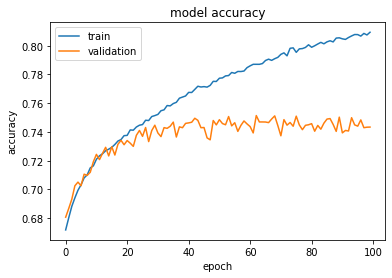

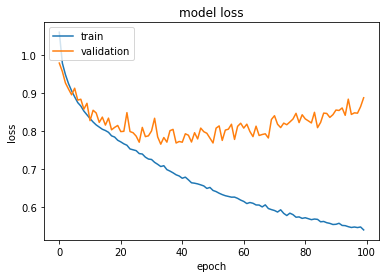

In [21]:
test_loss, test_acc = augmented_model.evaluate(XX_test, y_testarr, verbose=2)

print(augmented_history.history.keys())
#  "Accuracy"
plt.plot(augmented_history.history['accuracy'])
plt.plot(augmented_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(augmented_history.history['loss'])
plt.plot(augmented_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
augmented_model.save("augmented_best_modelno00")

INFO:tensorflow:Assets written to: augmented_best_modelno00\assets


### Using the k-fold cross-validation method to evaluate the best model and avoid overfitting

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 192)       3

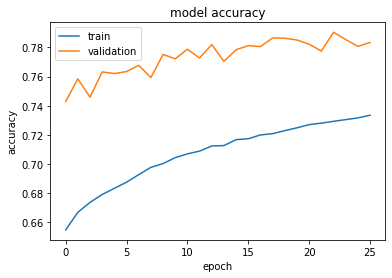

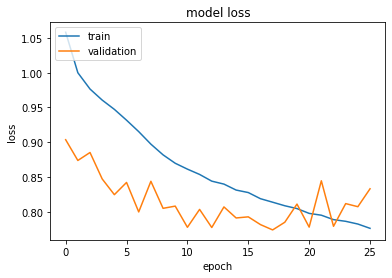

652/652 [==============================] - 5s 8ms/step - loss: 0.7794 - accuracy: 0.7905
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________

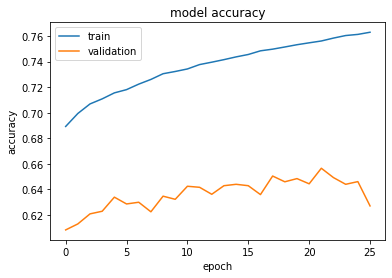

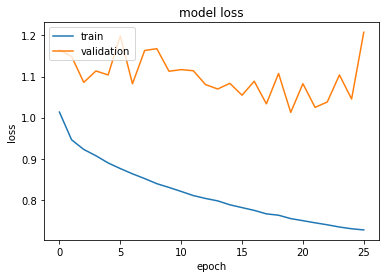

652/652 [==============================] - 6s 9ms/step - loss: 1.0250 - accuracy: 0.6565
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________

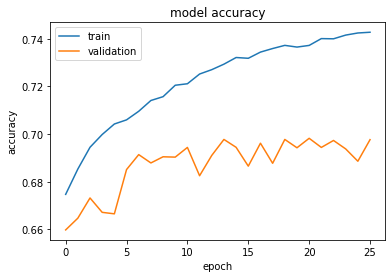

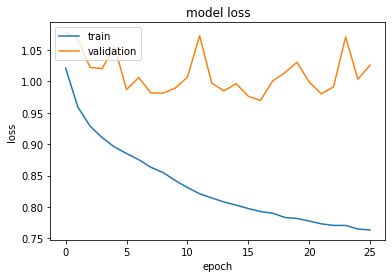

652/652 [==============================] - 6s 9ms/step - loss: 0.9991 - accuracy: 0.6982
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________

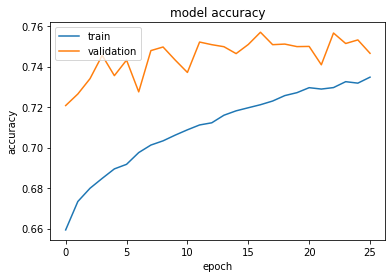

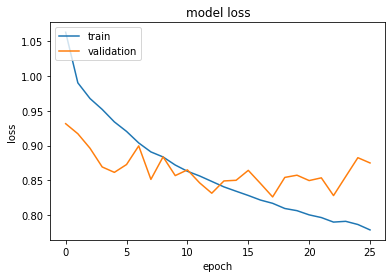

652/652 [==============================] - 5s 8ms/step - loss: 0.8454 - accuracy: 0.7569
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________

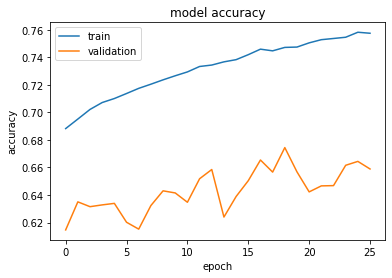

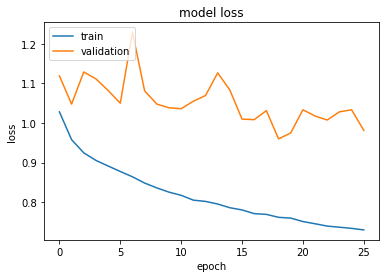

652/652 [==============================] - 5s 8ms/step - loss: 0.9599 - accuracy: 0.6744


In [3]:
train_labels_bands_1 = np.load("train_labels_bands_no00s.npy")
train_labels_lulc_1 = np.load("train_labels_lulc_no00s.npy")
train_labels_bands_1 = np.reshape(train_labels_bands_1, (-1, 33, 33, 6))

X = train_labels_bands_1
Y = np.repeat(train_labels_lulc_1, 12)

kf = KFold(n_splits = 5)                     

def get_model_name(k):
    return 'bmodel_'+str(k)+'.h5'

save_dir = "/saved_models/"
fold_var = 1
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

for train_index, val_index in kf.split(X, Y):
    Xx_train,yy_train = X[train_index],Y[train_index]
    Xx_test,yy_test = X[val_index],Y[val_index]
    
    
    # CREATE NEW MODEL
    bmodel = puremodel()
    # COMPILE NEW MODEL
    bmodel.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    history = bmodel.fit(Xx_train, yy_train,
                         epochs=26,
                         callbacks=callbacks_list,
                         validation_data= (Xx_test, yy_test))
    #PLOT HISTORY
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # LOAD BEST MODEL to evaluate the performance of the model
    bmodel.load_weights("/saved_models/bmodel_"+str(fold_var)+".h5")
    
    results = bmodel.evaluate(Xx_test, yy_test)
    results = dict(zip(bmodel.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDAITON_LOSS.append(results['loss'])
    

    tf.keras.backend.clear_session()

    fold_var += 1

In [4]:
#choosing the best model according to the metrics
print(VALIDATION_ACCURACY)
print(VALIDAITON_LOSS)

[0.7904524803161621, 0.6565211415290833, 0.698221743106842, 0.756938099861145, 0.6743996739387512]
[0.7794413566589355, 1.0249741077423096, 0.9991081953048706, 0.8454006314277649, 0.9598504304885864]


### Predicting classes for the instances in the 'only 'No DATA' class' dataset

In [9]:
zero_model.model = tf.keras.models.load_model("C:/saved_models/bmodel_1.h5")

import time
counter1 = 0
prediction = []
i = 0
prediction = zero_model.predict(zeros_bands)

for i in range(15684):
    start_time = time.time()
    midarr  = prediction[i]
    midint = np.where(midarr == np.amax(midarr))
    zeros_labl[i] = midint[0]
    counter1 += 1
    print(counter1)
    print("--- %s seconds ---" % (time.time() - start_time))
    
np.save('train_labels_lulc_00s', zeros_labl)
np.save('train_labels_bands_00s', zeros_bands)
print(zeros_labl)
print(zeros_labl[1583])

1
--- 0.0 seconds ---
2
--- 0.0 seconds ---
3
--- 0.0 seconds ---
4
--- 0.0 seconds ---
5
--- 0.0 seconds ---
6
--- 0.0 seconds ---
7
--- 0.0 seconds ---
8
--- 0.0 seconds ---
9
--- 0.0 seconds ---
10
--- 0.0 seconds ---
11
--- 0.0 seconds ---
12
--- 0.0 seconds ---
13
--- 0.0 seconds ---
14
--- 0.0010004043579101562 seconds ---
15
--- 0.0 seconds ---
16
--- 0.0 seconds ---
17
--- 0.0 seconds ---
18
--- 0.0009999275207519531 seconds ---
19
--- 0.0 seconds ---
20
--- 0.0 seconds ---
21
--- 0.0 seconds ---
22
--- 0.0 seconds ---
23
--- 0.0 seconds ---
24
--- 0.0 seconds ---
25
--- 0.0 seconds ---
26
--- 0.0 seconds ---
27
--- 0.0 seconds ---
28
--- 0.0 seconds ---
29
--- 0.0 seconds ---
30
--- 0.0 seconds ---
31
--- 0.0 seconds ---
32
--- 0.0 seconds ---
33
--- 0.0 seconds ---
34
--- 0.0 seconds ---
35
--- 0.0 seconds ---
36
--- 0.0 seconds ---
37
--- 0.0 seconds ---
38
--- 0.0 seconds ---
39
--- 0.0 seconds ---
40
--- 0.0 seconds ---
41
--- 0.0 seconds ---
42
--- 0.0 seconds ---
43
--- 

--- 0.025005817413330078 seconds ---
1579
--- 0.0 seconds ---
1580
--- 0.0 seconds ---
1581
--- 0.0 seconds ---
1582
--- 0.0 seconds ---
1583
--- 0.0 seconds ---
1584
--- 0.0 seconds ---
1585
--- 0.0 seconds ---
1586
--- 0.0 seconds ---
1587
--- 0.0 seconds ---
1588
--- 0.0 seconds ---
1589
--- 0.0 seconds ---
1590
--- 0.0 seconds ---
1591
--- 0.0 seconds ---
1592
--- 0.0 seconds ---
1593
--- 0.0 seconds ---
1594
--- 0.0 seconds ---
1595
--- 0.0 seconds ---
1596
--- 0.0 seconds ---
1597
--- 0.0 seconds ---
1598
--- 0.0 seconds ---
1599
--- 0.0 seconds ---
1600
--- 0.0 seconds ---
1601
--- 0.0 seconds ---
1602
--- 0.0 seconds ---
1603
--- 0.0010004043579101562 seconds ---
1604
--- 0.0 seconds ---
1605
--- 0.0 seconds ---
1606
--- 0.0 seconds ---
1607
--- 0.0 seconds ---
1608
--- 0.0 seconds ---
1609
--- 0.0 seconds ---
1610
--- 0.0 seconds ---
1611
--- 0.0 seconds ---
1612
--- 0.0 seconds ---
1613
--- 0.0 seconds ---
1614
--- 0.0 seconds ---
1615
--- 0.0 seconds ---
1616
--- 0.0 seconds

3078
--- 0.023005247116088867 seconds ---
3079
--- 0.0 seconds ---
3080
--- 0.0 seconds ---
3081
--- 0.0 seconds ---
3082
--- 0.0 seconds ---
3083
--- 0.0 seconds ---
3084
--- 0.0 seconds ---
3085
--- 0.0 seconds ---
3086
--- 0.0 seconds ---
3087
--- 0.0 seconds ---
3088
--- 0.0 seconds ---
3089
--- 0.0 seconds ---
3090
--- 0.0 seconds ---
3091
--- 0.0010001659393310547 seconds ---
3092
--- 0.0 seconds ---
3093
--- 0.0 seconds ---
3094
--- 0.0 seconds ---
3095
--- 0.0 seconds ---
3096
--- 0.0 seconds ---
3097
--- 0.0 seconds ---
3098
--- 0.0 seconds ---
3099
--- 0.0 seconds ---
3100
--- 0.0 seconds ---
3101
--- 0.0 seconds ---
3102
--- 0.0 seconds ---
3103
--- 0.0 seconds ---
3104
--- 0.0 seconds ---
3105
--- 0.0 seconds ---
3106
--- 0.0 seconds ---
3107
--- 0.0 seconds ---
3108
--- 0.0 seconds ---
3109
--- 0.0 seconds ---
3110
--- 0.0 seconds ---
3111
--- 0.0 seconds ---
3112
--- 0.0 seconds ---
3113
--- 0.0 seconds ---
3114
--- 0.0 seconds ---
3115
--- 0.0 seconds ---
3116
--- 0.0 se

4578
--- 0.0 seconds ---
4579
--- 0.0 seconds ---
4580
--- 0.0 seconds ---
4581
--- 0.0 seconds ---
4582
--- 0.0 seconds ---
4583
--- 0.0 seconds ---
4584
--- 0.0 seconds ---
4585
--- 0.0 seconds ---
4586
--- 0.0009999275207519531 seconds ---
4587
--- 0.0 seconds ---
4588
--- 0.0 seconds ---
4589
--- 0.0 seconds ---
4590
--- 0.0 seconds ---
4591
--- 0.0 seconds ---
4592
--- 0.0 seconds ---
4593
--- 0.0 seconds ---
4594
--- 0.0 seconds ---
4595
--- 0.0 seconds ---
4596
--- 0.0 seconds ---
4597
--- 0.0 seconds ---
4598
--- 0.0 seconds ---
4599
--- 0.0 seconds ---
4600
--- 0.0 seconds ---
4601
--- 0.0 seconds ---
4602
--- 0.0 seconds ---
4603
--- 0.0 seconds ---
4604
--- 0.0 seconds ---
4605
--- 0.0 seconds ---
4606
--- 0.0 seconds ---
4607
--- 0.0 seconds ---
4608
--- 0.0 seconds ---
4609
--- 0.0 seconds ---
4610
--- 0.0 seconds ---
4611
--- 0.0 seconds ---
4612
--- 0.0 seconds ---
4613
--- 0.0 seconds ---
4614
--- 0.0 seconds ---
4615
--- 0.0 seconds ---
4616
--- 0.0 seconds ---
4617
--

--- 0.0 seconds ---
6078
--- 0.0 seconds ---
6079
--- 0.0 seconds ---
6080
--- 0.0 seconds ---
6081
--- 0.0 seconds ---
6082
--- 0.0 seconds ---
6083
--- 0.0 seconds ---
6084
--- 0.0 seconds ---
6085
--- 0.0 seconds ---
6086
--- 0.0 seconds ---
6087
--- 0.0 seconds ---
6088
--- 0.0 seconds ---
6089
--- 0.0 seconds ---
6090
--- 0.0 seconds ---
6091
--- 0.0 seconds ---
6092
--- 0.0 seconds ---
6093
--- 0.0 seconds ---
6094
--- 0.0 seconds ---
6095
--- 0.0 seconds ---
6096
--- 0.0 seconds ---
6097
--- 0.0 seconds ---
6098
--- 0.0 seconds ---
6099
--- 0.0 seconds ---
6100
--- 0.0 seconds ---
6101
--- 0.0 seconds ---
6102
--- 0.0010006427764892578 seconds ---
6103
--- 0.0 seconds ---
6104
--- 0.0 seconds ---
6105
--- 0.0 seconds ---
6106
--- 0.0 seconds ---
6107
--- 0.0 seconds ---
6108
--- 0.0 seconds ---
6109
--- 0.0 seconds ---
6110
--- 0.0 seconds ---
6111
--- 0.0 seconds ---
6112
--- 0.0 seconds ---
6113
--- 0.0 seconds ---
6114
--- 0.0 seconds ---
6115
--- 0.0 seconds ---
6116
--- 0.0

--- 0.020004749298095703 seconds ---
7578
--- 0.0010001659393310547 seconds ---
7579
--- 0.0 seconds ---
7580
--- 0.0 seconds ---
7581
--- 0.0 seconds ---
7582
--- 0.0 seconds ---
7583
--- 0.0 seconds ---
7584
--- 0.0 seconds ---
7585
--- 0.0 seconds ---
7586
--- 0.0 seconds ---
7587
--- 0.0 seconds ---
7588
--- 0.0 seconds ---
7589
--- 0.0 seconds ---
7590
--- 0.0 seconds ---
7591
--- 0.0 seconds ---
7592
--- 0.0 seconds ---
7593
--- 0.0 seconds ---
7594
--- 0.0 seconds ---
7595
--- 0.0 seconds ---
7596
--- 0.0 seconds ---
7597
--- 0.0 seconds ---
7598
--- 0.0 seconds ---
7599
--- 0.0 seconds ---
7600
--- 0.0 seconds ---
7601
--- 0.0 seconds ---
7602
--- 0.0 seconds ---
7603
--- 0.0 seconds ---
7604
--- 0.0010004043579101562 seconds ---
7605
--- 0.0 seconds ---
7606
--- 0.0 seconds ---
7607
--- 0.0 seconds ---
7608
--- 0.0 seconds ---
7609
--- 0.0 seconds ---
7610
--- 0.0 seconds ---
7611
--- 0.0 seconds ---
7612
--- 0.0 seconds ---
7613
--- 0.0 seconds ---
7614
--- 0.0 seconds ---
76

9212
--- 0.0 seconds ---
9213
--- 0.0 seconds ---
9214
--- 0.0 seconds ---
9215
--- 0.0 seconds ---
9216
--- 0.0 seconds ---
9217
--- 0.0 seconds ---
9218
--- 0.0 seconds ---
9219
--- 0.0 seconds ---
9220
--- 0.0 seconds ---
9221
--- 0.0 seconds ---
9222
--- 0.0 seconds ---
9223
--- 0.0 seconds ---
9224
--- 0.0 seconds ---
9225
--- 0.0 seconds ---
9226
--- 0.0 seconds ---
9227
--- 0.0 seconds ---
9228
--- 0.0 seconds ---
9229
--- 0.0 seconds ---
9230
--- 0.0 seconds ---
9231
--- 0.0 seconds ---
9232
--- 0.0 seconds ---
9233
--- 0.0 seconds ---
9234
--- 0.0 seconds ---
9235
--- 0.0 seconds ---
9236
--- 0.0010001659393310547 seconds ---
9237
--- 0.0 seconds ---
9238
--- 0.0 seconds ---
9239
--- 0.0 seconds ---
9240
--- 0.0 seconds ---
9241
--- 0.0 seconds ---
9242
--- 0.0 seconds ---
9243
--- 0.0 seconds ---
9244
--- 0.0 seconds ---
9245
--- 0.0 seconds ---
9246
--- 0.0 seconds ---
9247
--- 0.0 seconds ---
9248
--- 0.0 seconds ---
9249
--- 0.0 seconds ---
9250
--- 0.0 seconds ---
9251
--

10827
--- 0.0 seconds ---
10828
--- 0.0 seconds ---
10829
--- 0.0 seconds ---
10830
--- 0.0 seconds ---
10831
--- 0.0 seconds ---
10832
--- 0.0 seconds ---
10833
--- 0.0 seconds ---
10834
--- 0.0010004043579101562 seconds ---
10835
--- 0.0 seconds ---
10836
--- 0.0 seconds ---
10837
--- 0.0 seconds ---
10838
--- 0.0 seconds ---
10839
--- 0.0 seconds ---
10840
--- 0.0 seconds ---
10841
--- 0.0 seconds ---
10842
--- 0.0 seconds ---
10843
--- 0.0 seconds ---
10844
--- 0.0 seconds ---
10845
--- 0.0 seconds ---
10846
--- 0.0 seconds ---
10847
--- 0.0 seconds ---
10848
--- 0.0 seconds ---
10849
--- 0.0 seconds ---
10850
--- 0.0 seconds ---
10851
--- 0.0 seconds ---
10852
--- 0.0 seconds ---
10853
--- 0.0 seconds ---
10854
--- 0.0 seconds ---
10855
--- 0.0 seconds ---
10856
--- 0.0 seconds ---
10857
--- 0.0 seconds ---
10858
--- 0.0 seconds ---
10859
--- 0.0 seconds ---
10860
--- 0.0 seconds ---
10861
--- 0.0 seconds ---
10862
--- 0.0 seconds ---
10863
--- 0.0 seconds ---
10864
--- 0.0 second

12531
--- 0.0010004043579101562 seconds ---
12532
--- 0.0 seconds ---
12533
--- 0.0 seconds ---
12534
--- 0.0 seconds ---
12535
--- 0.0 seconds ---
12536
--- 0.0 seconds ---
12537
--- 0.0 seconds ---
12538
--- 0.0 seconds ---
12539
--- 0.0 seconds ---
12540
--- 0.0 seconds ---
12541
--- 0.0 seconds ---
12542
--- 0.0 seconds ---
12543
--- 0.0 seconds ---
12544
--- 0.0 seconds ---
12545
--- 0.0 seconds ---
12546
--- 0.0 seconds ---
12547
--- 0.0 seconds ---
12548
--- 0.0 seconds ---
12549
--- 0.0 seconds ---
12550
--- 0.0010001659393310547 seconds ---
12551
--- 0.0 seconds ---
12552
--- 0.0 seconds ---
12553
--- 0.0 seconds ---
12554
--- 0.0 seconds ---
12555
--- 0.0 seconds ---
12556
--- 0.0 seconds ---
12557
--- 0.0 seconds ---
12558
--- 0.0 seconds ---
12559
--- 0.0 seconds ---
12560
--- 0.0 seconds ---
12561
--- 0.0 seconds ---
12562
--- 0.0 seconds ---
12563
--- 0.0 seconds ---
12564
--- 0.0 seconds ---
12565
--- 0.0 seconds ---
12566
--- 0.0 seconds ---
12567
--- 0.0 seconds ---
12

--- 0.018003225326538086 seconds ---
14077
--- 0.0 seconds ---
14078
--- 0.0 seconds ---
14079
--- 0.0 seconds ---
14080
--- 0.0 seconds ---
14081
--- 0.0 seconds ---
14082
--- 0.0 seconds ---
14083
--- 0.0 seconds ---
14084
--- 0.0 seconds ---
14085
--- 0.0 seconds ---
14086
--- 0.0 seconds ---
14087
--- 0.0 seconds ---
14088
--- 0.0 seconds ---
14089
--- 0.0 seconds ---
14090
--- 0.0 seconds ---
14091
--- 0.0 seconds ---
14092
--- 0.0 seconds ---
14093
--- 0.0 seconds ---
14094
--- 0.0010008811950683594 seconds ---
14095
--- 0.0 seconds ---
14096
--- 0.0 seconds ---
14097
--- 0.0 seconds ---
14098
--- 0.0 seconds ---
14099
--- 0.0 seconds ---
14100
--- 0.0 seconds ---
14101
--- 0.0 seconds ---
14102
--- 0.0 seconds ---
14103
--- 0.0 seconds ---
14104
--- 0.0 seconds ---
14105
--- 0.0 seconds ---
14106
--- 0.0 seconds ---
14107
--- 0.0 seconds ---
14108
--- 0.0 seconds ---
14109
--- 0.00099945068359375 seconds ---
14110
--- 0.0 seconds ---
14111
--- 0.0 seconds ---
14112
--- 0.0 secon

15576
--- 0.01700448989868164 seconds ---
15577
--- 0.0009987354278564453 seconds ---
15578
--- 0.0 seconds ---
15579
--- 0.0 seconds ---
15580
--- 0.0 seconds ---
15581
--- 0.0 seconds ---
15582
--- 0.0 seconds ---
15583
--- 0.0 seconds ---
15584
--- 0.0 seconds ---
15585
--- 0.0 seconds ---
15586
--- 0.0 seconds ---
15587
--- 0.0 seconds ---
15588
--- 0.0 seconds ---
15589
--- 0.0 seconds ---
15590
--- 0.0 seconds ---
15591
--- 0.0 seconds ---
15592
--- 0.0 seconds ---
15593
--- 0.0 seconds ---
15594
--- 0.0 seconds ---
15595
--- 0.0 seconds ---
15596
--- 0.0 seconds ---
15597
--- 0.001001119613647461 seconds ---
15598
--- 0.0 seconds ---
15599
--- 0.0 seconds ---
15600
--- 0.0 seconds ---
15601
--- 0.0 seconds ---
15602
--- 0.0 seconds ---
15603
--- 0.0 seconds ---
15604
--- 0.0 seconds ---
15605
--- 0.0 seconds ---
15606
--- 0.0 seconds ---
15607
--- 0.0 seconds ---
15608
--- 0.0 seconds ---
15609
--- 0.0 seconds ---
15610
--- 0.0 seconds ---
15611
--- 0.0 seconds ---
15612
--- 0.0

### Merging the new bands dataset with predicted classes for 'No DATA' and dataset without 'No DATA' class

In [ ]:
train_labels_bands_1 = np.load("train_labels_bands_no00s.npy")
train_labels_lulc_1 = np.load("train_labels_lulc_no00s.npy")
zeros_bands = np.load("train_labels_bands_00s.npy")
zeros_labl = np.load("train_labels_lulc_00s.npy")

united_lulc_pt1 = np.repeat(train_labels_lulc_1,12)
united_lulc_pt2 = zeros_labl
united_lulc = np.concatenate((united_lulc_pt1, united_lulc_pt2))

united_bands_pt1 = train_labels_bands_1
united_bands_pt2 = zeros_bands
united_bands = np.concatenate((united_bands_pt1, united_bands_pt2))

united_lulc = united_lulc.astype('int32')
np.save('united_lulc', united_lulc)
np.save('united_bands', united_bands)

## Augmenting new dataset

In [1]:
united_lulc = np.load("united_lulc.npy")
united_bands = np.load("united_bands.npy")

number = 0
id_zeros = []
Image_set1 = []
Image_set2 = []

#Find out inumber of cell(s) with zero value
for i in range(120000):
    if (united_bands[i].max() - united_bands[i].min()) == 0:
        number = number + 1
        
print (number)

#Finding indexes of this cells
for i in range(120000):
    if (united_bands[i].max() - united_bands[i].min()) == 0:
        indexx = i 
        id_zeros.append(indexx)

id_zeros = np.array(id_zeros)
print (id_zeros.size)

#Changing zero values  to process the augmentaion algorithm correctly
for i in range(id_zeros.size):
    united_bands[id_zeros[i],1,1,1] = 0.01

#Splitting data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(united_bands, united_lulc, test_size=0.25)

#Working on augmentation
for i in range(90000):
    image1 = np.array(X_train[i])
    seq = iaa.Sequential([
        iaa.Fliplr(0.56), # horizontal flips
        iaa.Flipud(0.46), # vertical flips,
        iaa.Sometimes(
            0.50, 
            iaa.OneOf([
                iaa.Affine(rotate=90), 
                iaa.Affine(rotate=-90)])
        )
    ], random_order=True)

    # Augment keypoints and images.
    image_aug1 = seq(image=image1)
    
    npimage_aug1 = np.array(image_aug1)
    Image_set1.append(npimage_aug1)

XX_train = np.array(Image_set1)
print(XX_train.shape)

for i in range(30000):
    image2 = np.array(X_test[i])

    seq = iaa.Sequential([
        iaa.Fliplr(0.46), # horizontal flips
        iaa.Flipud(0.53), # vertical flips,
        iaa.Sometimes(
            0.40, 
            iaa.OneOf([
                iaa.Affine(rotate=90), 
                iaa.Affine(rotate=-90)])
        )
    ], random_order=True)

    # Augment keypoints and images.
    image_aug2 = seq(image=image2)
    
    npimage_aug2 = np.array(image_aug2)
    Image_set2.append(npimage_aug2)

XX_test = np.array(Image_set2)
print(XX_test.shape)

y_trainarr = np.array(y_train)
y_testarr = np.array(y_test)

np.save('XX_test', XX_test)
np.save('XX_train', XX_train)
np.save('y_trainarr', y_trainarr)
np.save('y_testarr', y_testarr)

1
1
(90000, 33, 33, 6)
(30000, 33, 33, 6)


## Training the new model

In [3]:
augmented_model_last = puremodel()

XX_test = np.load("XX_test.npy")
XX_train = np.load("XX_train.npy")
y_trainarr = np.load("y_trainarr.npy")
y_testarr = np.load("y_testarr.npy")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 96)        5280      
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 192)       3

In [4]:
augmented_checkpoint_last = tf.keras.callbacks.ModelCheckpoint('augmented_model_last_best2.h5', 
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only= True, 
                             mode='auto')

In [5]:
augmented_model_last.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics = ['accuracy']) 

In [6]:
augmented_history_last = augmented_model_last.fit(XX_train, y_trainarr, batch_size=150, epochs = 25, 
                                                  validation_data=(XX_test, y_testarr), 
                                                  callbacks=[augmented_checkpoint_last])

Epoch 1/25
600/600 [==============================] - 74s 113ms/step - loss: 0.9827 - accuracy: 0.7007 - val_loss: 0.9286 - val_accuracy: 0.7072

Epoch 00001: val_accuracy improved from -inf to 0.70720, saving model to augmented_model_last_best2.h5
Epoch 2/25
600/600 [==============================] - 67s 112ms/step - loss: 0.9114 - accuracy: 0.7097 - val_loss: 0.8890 - val_accuracy: 0.7137

Epoch 00002: val_accuracy improved from 0.70720 to 0.71373, saving model to augmented_model_last_best2.h5
Epoch 3/25
600/600 [==============================] - 68s 113ms/step - loss: 0.8851 - accuracy: 0.7153 - val_loss: 0.8664 - val_accuracy: 0.7227

Epoch 00003: val_accuracy improved from 0.71373 to 0.72267, saving model to augmented_model_last_best2.h5
Epoch 4/25
600/600 [==============================] - 68s 113ms/step - loss: 0.8661 - accuracy: 0.7224 - val_loss: 0.8611 - val_accuracy: 0.7269

Epoch 00004: val_accuracy improved from 0.72267 to 0.72690, saving model to augmented_model_last_best

938/938 - 8s - loss: 0.7973 - accuracy: 0.7504
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


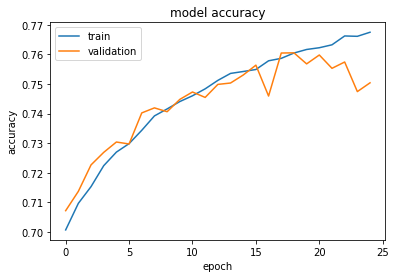

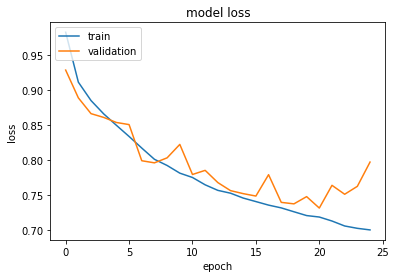

In [7]:
test_loss, test_acc = augmented_model_last.evaluate(XX_test, y_testarr, verbose=2)

print(augmented_history_last.history.keys())
#  "Accuracy"
plt.plot(augmented_history_last.history['accuracy'])
plt.plot(augmented_history_last.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(augmented_history_last.history['loss'])
plt.plot(augmented_history_last.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Getting the CNN prediction and plotting land cover

(12, 1500, 1500, 6)
(12, 1532, 1532, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


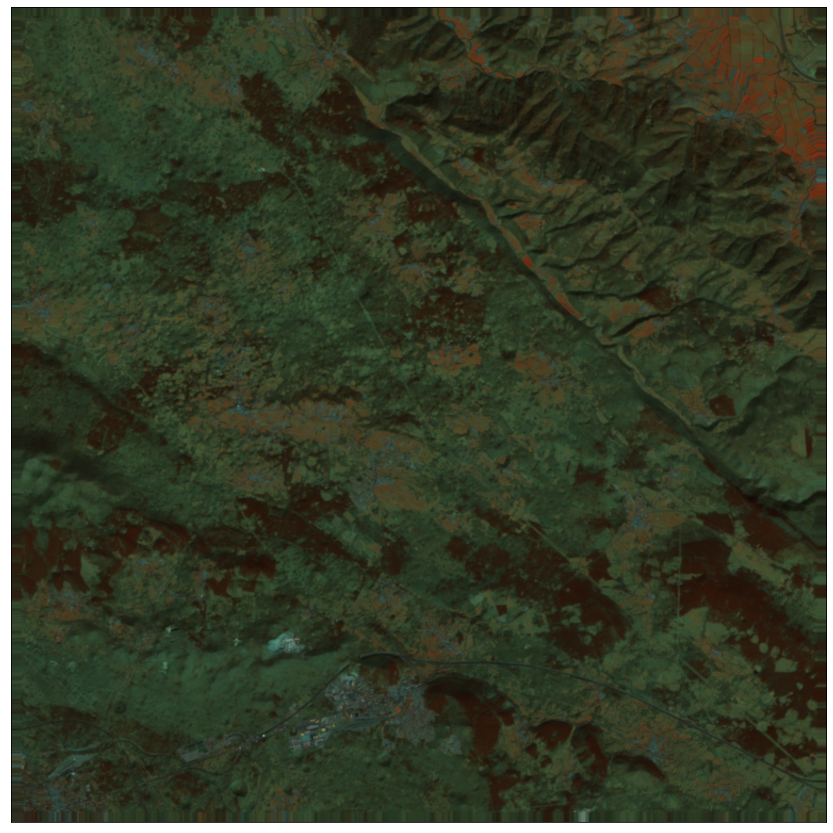

In [8]:
#Loading the model to predict
last_model = tf.keras.models.load_model("C:/Users/Alex/Desktop/Uni/DA2/augmented_model_last_best2.h5")

#Loading the hidden test set
Bublic_ful = np.load(path_10)['bands']
print(Bublic_ful.shape)
#Use cv2.copyMakeBorder fpr image padding. 
#Image should have 16 more pixels in all four directions in order to process right plotting.

ba2 = np.empty((12,1532,1532,6))

for i in range (12):   
    ba2[i] = cv2.copyMakeBorder(Bublic_ful[i], 16, 16, 16, 16, borderType = cv2.BORDER_REPLICATE)

print(ba2.shape)

ba2_split = np.array(np.split(ba2, 2, axis=3))
picpuc = ba2_split[1]
plt.figure(figsize=(15, 15))
plt.imshow(picpuc[3])
plt.xticks([]), plt.yticks([])
plt.show()

1
--- 3.753614664077759 sec ---
2
--- 0.03400754928588867 sec ---
3
--- 0.032007455825805664 sec ---
4
--- 0.033007144927978516 sec ---
5
--- 0.031007051467895508 sec ---
6
--- 0.031006813049316406 sec ---
7
--- 0.03000617027282715 sec ---
8
--- 0.03400731086730957 sec ---
9
--- 0.029006242752075195 sec ---
10
--- 0.0290067195892334 sec ---
11
--- 0.029006481170654297 sec ---
12
[[5.59813103e-08 1.73299620e-03 6.62726939e-01 2.55865186e-01
  7.85808638e-02 4.90541834e-06 2.19431966e-14 2.73674109e-14
  1.08219602e-03 6.92487720e-06 9.37437926e-14]
 [5.51226694e-05 8.39401037e-03 7.26045191e-01 1.68897241e-01
  8.11000764e-02 1.17479742e-03 8.66343552e-10 1.08801546e-09
  1.37891350e-02 5.44391049e-04 1.82013093e-09]
 [6.93557300e-09 2.85761850e-03 3.05646896e-01 6.10143781e-01
  7.71321505e-02 6.70482223e-06 3.09368958e-14 3.66560860e-14
  4.18704050e-03 2.58670116e-05 1.25330397e-13]
 [3.88987225e-08 5.08589018e-03 3.76372099e-01 5.12156248e-01
  1.01413772e-01 2.18875157e-05 3.309864

--- 0.029006481170654297 sec ---
170
--- 0.03000783920288086 sec ---
171
--- 0.029005765914916992 sec ---
172
--- 0.029006242752075195 sec ---
173
--- 0.03000783920288086 sec ---
174
--- 0.03300666809082031 sec ---
175
--- 0.029007434844970703 sec ---
176
--- 0.03000617027282715 sec ---
177
--- 0.029006004333496094 sec ---
178
--- 0.0290067195892334 sec ---
179
--- 0.029006242752075195 sec ---
180
--- 0.03000807762145996 sec ---
181
--- 0.02800583839416504 sec ---
182
--- 0.03300809860229492 sec ---
183
--- 0.03000617027282715 sec ---
184
--- 0.0290067195892334 sec ---
185
--- 0.028006315231323242 sec ---
186
--- 0.029006004333496094 sec ---
187
--- 0.0290067195892334 sec ---
188
--- 0.029006481170654297 sec ---
189
--- 0.030005693435668945 sec ---
190
--- 0.03300786018371582 sec ---
191
--- 0.029006004333496094 sec ---
192
--- 0.0290069580078125 sec ---
193
--- 0.02800607681274414 sec ---
194
--- 0.0290069580078125 sec ---
195
--- 0.028006315231323242 sec ---
196
--- 0.029006242752075

--- 0.0290067195892334 sec ---
395
--- 0.03000617027282715 sec ---
396
--- 0.030006885528564453 sec ---
397
--- 0.030006885528564453 sec ---
398
--- 0.029006481170654297 sec ---
399
--- 0.03300762176513672 sec ---
400
--- 0.0290069580078125 sec ---
401
--- 0.03000640869140625 sec ---
402
--- 0.0290069580078125 sec ---
403
--- 0.02800583839416504 sec ---
404
--- 0.02800607681274414 sec ---
405
--- 0.0290067195892334 sec ---
406
--- 0.028006315231323242 sec ---
407
--- 0.03200697898864746 sec ---
408
--- 0.030006885528564453 sec ---
409
--- 0.02800583839416504 sec ---
410
--- 0.02800583839416504 sec ---
411
--- 0.0290069580078125 sec ---
412
--- 0.02800583839416504 sec ---
413
--- 0.0290071964263916 sec ---
414
--- 0.028014183044433594 sec ---
415
--- 0.03400754928588867 sec ---
416
--- 0.03000640869140625 sec ---
417
--- 0.02800583839416504 sec ---
418
--- 0.0290069580078125 sec ---
419
--- 0.02800607681274414 sec ---
420
--- 0.028006315231323242 sec ---
421
--- 0.02800607681274414 sec 

--- 0.030007123947143555 sec ---
628
--- 0.029006242752075195 sec ---
629
--- 0.02800607681274414 sec ---
630
--- 0.02800607681274414 sec ---
631
--- 0.03300786018371582 sec ---
632
--- 0.02800583839416504 sec ---
633
--- 0.029008865356445312 sec ---
634
--- 0.028003692626953125 sec ---
635
--- 0.03000640869140625 sec ---
636
--- 0.028006315231323242 sec ---
637
--- 0.028006553649902344 sec ---
638
--- 0.02800583839416504 sec ---
639
--- 0.03200697898864746 sec ---
640
--- 0.028006315231323242 sec ---
641
--- 0.03000617027282715 sec ---
642
--- 0.0290067195892334 sec ---
643
--- 0.029006481170654297 sec ---
644
--- 0.0290067195892334 sec ---
645
--- 0.02800607681274414 sec ---
646
--- 0.028006315231323242 sec ---
647
--- 0.03200721740722656 sec ---
648
--- 0.029006004333496094 sec ---
649
--- 0.028006315231323242 sec ---
650
--- 0.02800583839416504 sec ---
651
--- 0.0290069580078125 sec ---
652
--- 0.02800583839416504 sec ---
653
--- 0.02800607681274414 sec ---
654
--- 0.02800631523132

--- 0.02800583839416504 sec ---
859
--- 0.030007362365722656 sec ---
860
--- 0.029006004333496094 sec ---
861
--- 0.028006792068481445 sec ---
862
--- 0.029006004333496094 sec ---
863
--- 0.032007455825805664 sec ---
864
--- 0.02800607681274414 sec ---
865
--- 0.030006885528564453 sec ---
866
--- 0.0290067195892334 sec ---
867
--- 0.03000640869140625 sec ---
868
--- 0.028006553649902344 sec ---
869
--- 0.028006792068481445 sec ---
870
--- 0.028005599975585938 sec ---
871
--- 0.032007455825805664 sec ---
872
--- 0.029006242752075195 sec ---
873
--- 0.029006481170654297 sec ---
874
--- 0.029006481170654297 sec ---
875
--- 0.028006553649902344 sec ---
876
--- 0.028006792068481445 sec ---
877
--- 0.028014183044433594 sec ---
878
--- 0.028998374938964844 sec ---
879
--- 0.033006906509399414 sec ---
880
--- 0.028006553649902344 sec ---
881
--- 0.02800607681274414 sec ---
882
--- 0.028006315231323242 sec ---
883
--- 0.028005599975585938 sec ---
884
--- 0.028006553649902344 sec ---
885
--- 0.0

--- 0.028998613357543945 sec ---
1086
--- 0.03000664710998535 sec ---
1087
--- 0.03200721740722656 sec ---
1088
--- 0.0290067195892334 sec ---
1089
--- 0.02800607681274414 sec ---
1090
--- 0.0290067195892334 sec ---
1091
--- 0.02800583839416504 sec ---
1092
--- 0.030007123947143555 sec ---
1093
--- 0.028006315231323242 sec ---
1094
--- 0.0290067195892334 sec ---
1095
--- 0.03300738334655762 sec ---
1096
--- 0.0290069580078125 sec ---
1097
--- 0.028006315231323242 sec ---
1098
--- 0.029006242752075195 sec ---
1099
--- 0.030006885528564453 sec ---
1100
--- 0.029006242752075195 sec ---
1101
--- 0.028006315231323242 sec ---
1102
--- 0.0290069580078125 sec ---
1103
--- 0.03200721740722656 sec ---
1104
--- 0.029006481170654297 sec ---
1105
--- 0.028006315231323242 sec ---
1106
--- 0.0290067195892334 sec ---
1107
--- 0.02800607681274414 sec ---
1108
--- 0.029006481170654297 sec ---
1109
--- 0.0290071964263916 sec ---
1110
--- 0.028005599975585938 sec ---
1111
--- 0.03200721740722656 sec ---
1

--- 0.028014421463012695 sec ---
1310
--- 0.028998613357543945 sec ---
1311
--- 0.03300738334655762 sec ---
1312
--- 0.029006004333496094 sec ---
1313
--- 0.0290069580078125 sec ---
1314
--- 0.02800607681274414 sec ---
1315
--- 0.0290067195892334 sec ---
1316
--- 0.028006553649902344 sec ---
1317
--- 0.029006004333496094 sec ---
1318
--- 0.02800583839416504 sec ---
1319
--- 0.03300786018371582 sec ---
1320
--- 0.14404058456420898 sec ---
1321
--- 0.02899909019470215 sec ---
1322
--- 0.02801370620727539 sec ---
1323
--- 0.028014659881591797 sec ---
1324
--- 0.02899765968322754 sec ---
1325
--- 0.028006792068481445 sec ---
1326
--- 0.028006315231323242 sec ---
1327
--- 0.031006336212158203 sec ---
1328
--- 0.02800583839416504 sec ---
1329
--- 0.030006885528564453 sec ---
1330
--- 0.028006315231323242 sec ---
1331
--- 0.02800607681274414 sec ---
1332
--- 0.028006553649902344 sec ---
1333
--- 0.02800583839416504 sec ---
1334
--- 0.028006315231323242 sec ---
1335
--- 0.03300738334655762 sec

--- 0.0290069580078125 sec ---
1532
--- 0.03000617027282715 sec ---
1533
--- 0.02800583839416504 sec ---
1534
--- 0.0290067195892334 sec ---
1535
--- 0.032007455825805664 sec ---
1536
--- 0.029006004333496094 sec ---
1537
--- 0.02800583839416504 sec ---
1538
--- 0.028006315231323242 sec ---
1539
--- 0.02800583839416504 sec ---
1540
--- 0.02700638771057129 sec ---
1541
--- 0.029006242752075195 sec ---
1542
--- 0.0290069580078125 sec ---
1543
--- 0.03300738334655762 sec ---
1544
--- 0.029006481170654297 sec ---
1545
--- 0.030006885528564453 sec ---
1546
--- 0.029006481170654297 sec ---
1547
--- 0.0290071964263916 sec ---
1548
--- 0.028005361557006836 sec ---
1549
--- 0.0290067195892334 sec ---
1550
--- 0.028006792068481445 sec ---
1551
--- 0.03300738334655762 sec ---
1552
--- 0.03000664710998535 sec ---
1553
--- 0.0290067195892334 sec ---
1554
--- 0.029006481170654297 sec ---
1555
--- 0.029006242752075195 sec ---
1556
--- 0.02800607681274414 sec ---
1557
--- 0.028006315231323242 sec ---


--- 0.028005599975585938 sec ---
1751
--- 0.03400826454162598 sec ---
1752
--- 0.029006004333496094 sec ---
1753
--- 0.0290067195892334 sec ---
1754
--- 0.02800583839416504 sec ---
1755
--- 0.0290069580078125 sec ---
1756
--- 0.02800607681274414 sec ---
1757
--- 0.0290067195892334 sec ---
1758
--- 0.03000617027282715 sec ---
1759
--- 0.03300809860229492 sec ---
1760
--- 0.030006885528564453 sec ---
1761
--- 0.029006242752075195 sec ---
1762
--- 0.0290071964263916 sec ---
1763
--- 0.028005599975585938 sec ---
1764
--- 0.030006885528564453 sec ---
1765
--- 0.029006481170654297 sec ---
1766
--- 0.029006242752075195 sec ---
1767
--- 0.03300762176513672 sec ---
1768
--- 0.02800607681274414 sec ---
1769
--- 0.02800607681274414 sec ---
1770
--- 0.02800583839416504 sec ---
1771
--- 0.030007123947143555 sec ---
1772
--- 0.029006481170654297 sec ---
1773
--- 0.029006481170654297 sec ---
1774
--- 0.029006481170654297 sec ---
1775
--- 0.03300738334655762 sec ---
1776
--- 0.0290067195892334 sec ---

--- 0.02900552749633789 sec ---
1973
--- 0.030007600784301758 sec ---
1974
--- 0.029005765914916992 sec ---
1975
--- 0.0290067195892334 sec ---
1976
--- 0.03300738334655762 sec ---
1977
--- 0.029005765914916992 sec ---
1978
--- 0.0290071964263916 sec ---
1979
--- 0.03000617027282715 sec ---
1980
--- 0.0290067195892334 sec ---
1981
--- 0.029006481170654297 sec ---
1982
--- 0.0290067195892334 sec ---
1983
--- 0.029006242752075195 sec ---
1984
--- 0.03200674057006836 sec ---
1985
--- 0.0290067195892334 sec ---
1986
--- 0.030006885528564453 sec ---
1987
--- 0.029006004333496094 sec ---
1988
--- 0.0290067195892334 sec ---
1989
--- 0.029006242752075195 sec ---
1990
--- 0.029006481170654297 sec ---
1991
--- 0.0290069580078125 sec ---
1992
--- 0.03200697898864746 sec ---
1993
--- 0.03000664710998535 sec ---
1994
--- 0.029006242752075195 sec ---
1995
--- 0.0290067195892334 sec ---
1996
--- 0.029006481170654297 sec ---
1997
--- 0.030007123947143555 sec ---
1998
--- 0.029006242752075195 sec ---
1

--- 0.03300762176513672 sec ---
2193
--- 0.031006813049316406 sec ---
2194
--- 0.029006481170654297 sec ---
2195
--- 0.0290067195892334 sec ---
2196
--- 0.03000640869140625 sec ---
2197
--- 0.0290067195892334 sec ---
2198
--- 0.0290067195892334 sec ---
2199
--- 0.029006481170654297 sec ---
2200
--- 0.033007144927978516 sec ---
2201
--- 0.0290069580078125 sec ---
2202
--- 0.029006242752075195 sec ---
2203
--- 0.028006553649902344 sec ---
2204
--- 0.02800607681274414 sec ---
2205
--- 0.028014659881591797 sec ---
2206
--- 0.029006481170654297 sec ---
2207
--- 0.03000664710998535 sec ---
2208
--- 0.033007144927978516 sec ---
2209
--- 0.02800583839416504 sec ---
2210
--- 0.0290071964263916 sec ---
2211
--- 0.029006242752075195 sec ---
2212
--- 0.028006553649902344 sec ---
2213
--- 0.03000640869140625 sec ---
2214
--- 0.0290069580078125 sec ---
2215
--- 0.029006242752075195 sec ---
2216
--- 0.03300762176513672 sec ---
2217
--- 0.028014183044433594 sec ---
2218
--- 0.028016090393066406 sec --

--- 0.030006885528564453 sec ---
2412
--- 0.03000664710998535 sec ---
2413
--- 0.0290067195892334 sec ---
2414
--- 0.02800583839416504 sec ---
2415
--- 0.0290067195892334 sec ---
2416
--- 0.15203452110290527 sec ---
2417
--- 0.029006004333496094 sec ---
2418
--- 0.029006481170654297 sec ---
2419
--- 0.029006481170654297 sec ---
2420
--- 0.0290067195892334 sec ---
2421
--- 0.0290067195892334 sec ---
2422
--- 0.02800583839416504 sec ---
2423
--- 0.029006242752075195 sec ---
2424
--- 0.03400826454162598 sec ---
2425
--- 0.029006242752075195 sec ---
2426
--- 0.0290069580078125 sec ---
2427
--- 0.029006242752075195 sec ---
2428
--- 0.0290069580078125 sec ---
2429
--- 0.028006315231323242 sec ---
2430
--- 0.02800583839416504 sec ---
2431
--- 0.02900552749633789 sec ---
2432
--- 0.03200697898864746 sec ---
2433
--- 0.0290067195892334 sec ---
2434
--- 0.0290069580078125 sec ---
2435
--- 0.030006885528564453 sec ---
2436
--- 0.02800607681274414 sec ---
2437
--- 0.0290067195892334 sec ---
2438
-

--- 0.031006574630737305 sec ---
2636
--- 0.03000664710998535 sec ---
2637
--- 0.031006336212158203 sec ---
2638
--- 0.030007600784301758 sec ---
2639
--- 0.031007051467895508 sec ---
2640
--- 0.03400754928588867 sec ---
2641
--- 0.029006481170654297 sec ---
2642
--- 0.0290067195892334 sec ---
2643
--- 0.03000640869140625 sec ---
2644
--- 0.0290069580078125 sec ---
2645
--- 0.0290069580078125 sec ---
2646
--- 0.029006004333496094 sec ---
2647
--- 0.029006242752075195 sec ---
2648
--- 0.03200674057006836 sec ---
2649
--- 0.03000664710998535 sec ---
2650
--- 0.0290067195892334 sec ---
2651
--- 0.029006481170654297 sec ---
2652
--- 0.029006242752075195 sec ---
2653
--- 0.029006004333496094 sec ---
2654
--- 0.029006481170654297 sec ---
2655
--- 0.02800583839416504 sec ---
2656
--- 0.03500819206237793 sec ---
2657
--- 0.029006481170654297 sec ---
2658
--- 0.029006242752075195 sec ---
2659
--- 0.030007600784301758 sec ---
2660
--- 0.029006004333496094 sec ---
2661
--- 0.0290067195892334 sec 

--- 0.029006242752075195 sec ---
2860
--- 0.03100728988647461 sec ---
2861
--- 0.029006481170654297 sec ---
2862
--- 0.029006481170654297 sec ---
2863
--- 0.029006242752075195 sec ---
2864
--- 0.03300786018371582 sec ---
2865
--- 0.03000640869140625 sec ---
2866
--- 0.0290067195892334 sec ---
2867
--- 0.031006813049316406 sec ---
2868
--- 0.0290067195892334 sec ---
2869
--- 0.031006336212158203 sec ---
2870
--- 0.030007123947143555 sec ---
2871
--- 0.029006481170654297 sec ---
2872
--- 0.034008026123046875 sec ---
2873
--- 0.03200721740722656 sec ---
2874
--- 0.03000640869140625 sec ---
2875
--- 0.029006242752075195 sec ---
2876
--- 0.030007123947143555 sec ---
2877
--- 0.029006481170654297 sec ---
2878
--- 0.029006481170654297 sec ---
2879
--- 0.029006242752075195 sec ---
2880
--- 0.03500819206237793 sec ---
2881
--- 0.029006004333496094 sec ---
2882
--- 0.03000783920288086 sec ---
2883
--- 0.02900552749633789 sec ---
2884
--- 0.029006481170654297 sec ---
2885
--- 0.029006242752075195

--- 0.02700638771057129 sec ---
3080
--- 0.03200674057006836 sec ---
3081
--- 0.029006481170654297 sec ---
3082
--- 0.0290067195892334 sec ---
3083
--- 0.028006553649902344 sec ---
3084
--- 0.030007123947143555 sec ---
3085
--- 0.029006242752075195 sec ---
3086
--- 0.030006885528564453 sec ---
3087
--- 0.029005765914916992 sec ---
3088
--- 0.03300738334655762 sec ---
3089
--- 0.029006481170654297 sec ---
3090
--- 0.02800583839416504 sec ---
3091
--- 0.030007123947143555 sec ---
3092
--- 0.029006481170654297 sec ---
3093
--- 0.03000664710998535 sec ---
3094
--- 0.029006481170654297 sec ---
3095
--- 0.030007123947143555 sec ---
3096
--- 0.03300738334655762 sec ---
3097
--- 0.030007362365722656 sec ---
3098
--- 0.029006242752075195 sec ---
3099
--- 0.03000664710998535 sec ---
3100
--- 0.0290067195892334 sec ---
3101
--- 0.03000640869140625 sec ---
3102
--- 0.0290067195892334 sec ---
3103
--- 0.029006481170654297 sec ---
3104
--- 0.03300762176513672 sec ---
3105
--- 0.029006481170654297 se

--- 0.030005931854248047 sec ---
3302
--- 0.03100752830505371 sec ---
3303
--- 0.03000640869140625 sec ---
3304
--- 0.034008026123046875 sec ---
3305
--- 0.03000617027282715 sec ---
3306
--- 0.030007123947143555 sec ---
3307
--- 0.029006481170654297 sec ---
3308
--- 0.030007362365722656 sec ---
3309
--- 0.030007362365722656 sec ---
3310
--- 0.029006004333496094 sec ---
3311
--- 0.0290067195892334 sec ---
3312
--- 0.03300762176513672 sec ---
3313
--- 0.029006481170654297 sec ---
3314
--- 0.031007051467895508 sec ---
3315
--- 0.030006885528564453 sec ---
3316
--- 0.0290067195892334 sec ---
3317
--- 0.029006242752075195 sec ---
3318
--- 0.029006481170654297 sec ---
3319
--- 0.0290067195892334 sec ---
3320
--- 0.03300762176513672 sec ---
3321
--- 0.029006242752075195 sec ---
3322
--- 0.0290067195892334 sec ---
3323
--- 0.029006481170654297 sec ---
3324
--- 0.028006315231323242 sec ---
3325
--- 0.029005765914916992 sec ---
3326
--- 0.0290067195892334 sec ---
3327
--- 0.029006004333496094 se

--- 0.02800583839416504 sec ---
3521
--- 0.033007144927978516 sec ---
3522
--- 0.029006481170654297 sec ---
3523
--- 0.029006242752075195 sec ---
3524
--- 0.029006481170654297 sec ---
3525
--- 0.0290067195892334 sec ---
3526
--- 0.02800583839416504 sec ---
3527
--- 0.028005599975585938 sec ---
3528
--- 0.030006885528564453 sec ---
3529
--- 0.03300738334655762 sec ---
3530
--- 0.029006481170654297 sec ---
3531
--- 0.029006481170654297 sec ---
3532
--- 0.029006481170654297 sec ---
3533
--- 0.030007123947143555 sec ---
3534
--- 0.03000640869140625 sec ---
3535
--- 0.029006481170654297 sec ---
3536
--- 0.0290067195892334 sec ---
3537
--- 0.033007144927978516 sec ---
3538
--- 0.028006315231323242 sec ---
3539
--- 0.028014659881591797 sec ---
3540
--- 0.028006553649902344 sec ---
3541
--- 0.028006553649902344 sec ---
3542
--- 0.027005434036254883 sec ---
3543
--- 0.02800607681274414 sec ---
3544
--- 0.029006242752075195 sec ---
3545
--- 0.03300762176513672 sec ---
3546
--- 0.0290067195892334

--- 0.031006813049316406 sec ---
3743
--- 0.03200721740722656 sec ---
3744
--- 0.031007051467895508 sec ---
3745
--- 0.03500771522521973 sec ---
3746
--- 0.030007123947143555 sec ---
3747
--- 0.029006242752075195 sec ---
3748
--- 0.030007362365722656 sec ---
3749
--- 0.03200650215148926 sec ---
3750
--- 0.029006481170654297 sec ---
3751
--- 0.0290069580078125 sec ---
3752
--- 0.030006885528564453 sec ---
3753
--- 0.03300666809082031 sec ---
3754
--- 0.030007362365722656 sec ---
3755
--- 0.03200697898864746 sec ---
3756
--- 0.03000664710998535 sec ---
3757
--- 0.030007123947143555 sec ---
3758
--- 0.029006242752075195 sec ---
3759
--- 0.029006481170654297 sec ---
3760
--- 0.03200936317443848 sec ---
3761
--- 0.03500676155090332 sec ---
3762
--- 0.031006336212158203 sec ---
3763
--- 0.030007362365722656 sec ---
3764
--- 0.03100752830505371 sec ---
3765
--- 0.03000664710998535 sec ---
3766
--- 0.029006481170654297 sec ---
3767
--- 0.03000640869140625 sec ---
3768
--- 0.0290067195892334 se

--- 0.030007123947143555 sec ---
3963
--- 0.03000664710998535 sec ---
3964
--- 0.030007123947143555 sec ---
3965
--- 0.029006004333496094 sec ---
3966
--- 0.0290067195892334 sec ---
3967
--- 0.029006481170654297 sec ---
3968
--- 0.029006481170654297 sec ---
3969
--- 0.03400826454162598 sec ---
3970
--- 0.029006004333496094 sec ---
3971
--- 0.03000617027282715 sec ---
3972
--- 0.029006242752075195 sec ---
3973
--- 0.029006481170654297 sec ---
3974
--- 0.029006481170654297 sec ---
3975
--- 0.030006885528564453 sec ---
3976
--- 0.030006885528564453 sec ---
3977
--- 0.032007455825805664 sec ---
3978
--- 0.029005765914916992 sec ---
3979
--- 0.02800583839416504 sec ---
3980
--- 0.0290071964263916 sec ---
3981
--- 0.029006004333496094 sec ---
3982
--- 0.03100728988647461 sec ---
3983
--- 0.029006004333496094 sec ---
3984
--- 0.0290069580078125 sec ---
3985
--- 0.03300738334655762 sec ---
3986
--- 0.029005765914916992 sec ---
3987
--- 0.030007600784301758 sec ---
3988
--- 0.030007123947143555

--- 0.03000664710998535 sec ---
4182
--- 0.03000617027282715 sec ---
4183
--- 0.0290069580078125 sec ---
4184
--- 0.0290067195892334 sec ---
4185
--- 0.03300762176513672 sec ---
4186
--- 0.03000617027282715 sec ---
4187
--- 0.0290067195892334 sec ---
4188
--- 0.03000640869140625 sec ---
4189
--- 0.029006242752075195 sec ---
4190
--- 0.0290071964263916 sec ---
4191
--- 0.02900552749633789 sec ---
4192
--- 0.030007600784301758 sec ---
4193
--- 0.033006906509399414 sec ---
4194
--- 0.0290069580078125 sec ---
4195
--- 0.030005931854248047 sec ---
4196
--- 0.0290071964263916 sec ---
4197
--- 0.030006885528564453 sec ---
4198
--- 0.029006481170654297 sec ---
4199
--- 0.02800607681274414 sec ---
4200
--- 0.028005361557006836 sec ---
4201
--- 0.03300762176513672 sec ---
4202
--- 0.029006004333496094 sec ---
4203
--- 0.029006481170654297 sec ---
4204
--- 0.029006481170654297 sec ---
4205
--- 0.029006242752075195 sec ---
4206
--- 0.029006004333496094 sec ---
4207
--- 0.030007362365722656 sec ---

--- 0.029006242752075195 sec ---
4401
--- 0.03400754928588867 sec ---
4402
--- 0.029006481170654297 sec ---
4403
--- 0.0290067195892334 sec ---
4404
--- 0.029006242752075195 sec ---
4405
--- 0.029006004333496094 sec ---
4406
--- 0.029006242752075195 sec ---
4407
--- 0.029006242752075195 sec ---
4408
--- 0.030007123947143555 sec ---
4409
--- 0.033007144927978516 sec ---
4410
--- 0.02800583839416504 sec ---
4411
--- 0.029006481170654297 sec ---
4412
--- 0.030006885528564453 sec ---
4413
--- 0.029006481170654297 sec ---
4414
--- 0.03000640869140625 sec ---
4415
--- 0.0290069580078125 sec ---
4416
--- 0.029006242752075195 sec ---
4417
--- 0.03300762176513672 sec ---
4418
--- 0.0290067195892334 sec ---
4419
--- 0.029006481170654297 sec ---
4420
--- 0.0290067195892334 sec ---
4421
--- 0.030006885528564453 sec ---
4422
--- 0.029006004333496094 sec ---
4423
--- 0.029006481170654297 sec ---
4424
--- 0.030007362365722656 sec ---
4425
--- 0.033007144927978516 sec ---
4426
--- 0.0290067195892334 s

--- 0.029006481170654297 sec ---
4624
--- 0.031007051467895508 sec ---
4625
--- 0.03300762176513672 sec ---
4626
--- 0.029006242752075195 sec ---
4627
--- 0.029006481170654297 sec ---
4628
--- 0.029006481170654297 sec ---
4629
--- 0.0290069580078125 sec ---
4630
--- 0.03000640869140625 sec ---
4631
--- 0.030007123947143555 sec ---
4632
--- 0.03000617027282715 sec ---
4633
--- 0.03300738334655762 sec ---
4634
--- 0.0290069580078125 sec ---
4635
--- 0.029007434844970703 sec ---
4636
--- 0.0290067195892334 sec ---
4637
--- 0.030006885528564453 sec ---
4638
--- 0.03000640869140625 sec ---
4639
--- 0.029006004333496094 sec ---
4640
--- 0.0290067195892334 sec ---
4641
--- 0.03300738334655762 sec ---
4642
--- 0.030005931854248047 sec ---
4643
--- 0.03000664710998535 sec ---
4644
--- 0.031007051467895508 sec ---
4645
--- 0.0290067195892334 sec ---
4646
--- 0.0290067195892334 sec ---
4647
--- 0.029005765914916992 sec ---
4648
--- 0.028005599975585938 sec ---
4649
--- 0.03300786018371582 sec ---

--- 0.029006481170654297 sec ---
4847
--- 0.030006885528564453 sec ---
4848
--- 0.029006242752075195 sec ---
4849
--- 0.03300738334655762 sec ---
4850
--- 0.03000664710998535 sec ---
4851
--- 0.029006481170654297 sec ---
4852
--- 0.02800583839416504 sec ---
4853
--- 0.029006004333496094 sec ---
4854
--- 0.031007051467895508 sec ---
4855
--- 0.029006242752075195 sec ---
4856
--- 0.030007123947143555 sec ---
4857
--- 0.033006906509399414 sec ---
4858
--- 0.0290069580078125 sec ---
4859
--- 0.029006242752075195 sec ---
4860
--- 0.0290067195892334 sec ---
4861
--- 0.03100752830505371 sec ---
4862
--- 0.029006242752075195 sec ---
4863
--- 0.029006004333496094 sec ---
4864
--- 0.0290069580078125 sec ---
4865
--- 0.03300738334655762 sec ---
4866
--- 0.02800583839416504 sec ---
4867
--- 0.029007434844970703 sec ---
4868
--- 0.0310060977935791 sec ---
4869
--- 0.0290069580078125 sec ---
4870
--- 0.029006481170654297 sec ---
4871
--- 0.029006481170654297 sec ---
4872
--- 0.02800607681274414 sec 

--- 0.029006242752075195 sec ---
5071
--- 0.030006885528564453 sec ---
5072
--- 0.030006885528564453 sec ---
5073
--- 0.03300762176513672 sec ---
5074
--- 0.03000664710998535 sec ---
5075
--- 0.029006481170654297 sec ---
5076
--- 0.030007123947143555 sec ---
5077
--- 0.030007123947143555 sec ---
5078
--- 0.029006481170654297 sec ---
5079
--- 0.029006481170654297 sec ---
5080
--- 0.02800583839416504 sec ---
5081
--- 0.032007694244384766 sec ---
5082
--- 0.027005434036254883 sec ---
5083
--- 0.029006481170654297 sec ---
5084
--- 0.03000640869140625 sec ---
5085
--- 0.030007123947143555 sec ---
5086
--- 0.029006481170654297 sec ---
5087
--- 0.0290067195892334 sec ---
5088
--- 0.029006481170654297 sec ---
5089
--- 0.03300762176513672 sec ---
5090
--- 0.029006242752075195 sec ---
5091
--- 0.02800607681274414 sec ---
5092
--- 0.029007673263549805 sec ---
5093
--- 0.029005765914916992 sec ---
5094
--- 0.0290067195892334 sec ---
5095
--- 0.0290067195892334 sec ---
5096
--- 0.02900552749633789 

--- 0.030007362365722656 sec ---
5293
--- 0.03000617027282715 sec ---
5294
--- 0.030007362365722656 sec ---
5295
--- 0.029006481170654297 sec ---
5296
--- 0.029006481170654297 sec ---
5297
--- 0.0290071964263916 sec ---
5298
--- 0.033007144927978516 sec ---
5299
--- 0.03000664710998535 sec ---
5300
--- 0.03000640869140625 sec ---
5301
--- 0.029006481170654297 sec ---
5302
--- 0.030007123947143555 sec ---
5303
--- 0.029006481170654297 sec ---
5304
--- 0.029006004333496094 sec ---
5305
--- 0.0290071964263916 sec ---
5306
--- 0.03500795364379883 sec ---
5307
--- 0.029006242752075195 sec ---
5308
--- 0.029006481170654297 sec ---
5309
--- 0.0290067195892334 sec ---
5310
--- 0.029006481170654297 sec ---
5311
--- 0.0290067195892334 sec ---
5312
--- 0.029006242752075195 sec ---
5313
--- 0.030006885528564453 sec ---
5314
--- 0.03300738334655762 sec ---
5315
--- 0.0290067195892334 sec ---
5316
--- 0.029006004333496094 sec ---
5317
--- 0.0290071964263916 sec ---
5318
--- 0.029006004333496094 sec 

--- 0.029006004333496094 sec ---
5516
--- 0.03100728988647461 sec ---
5517
--- 0.0290067195892334 sec ---
5518
--- 0.029006481170654297 sec ---
5519
--- 0.029006004333496094 sec ---
5520
--- 0.0290069580078125 sec ---
5521
--- 0.030007123947143555 sec ---
5522
--- 0.03300929069519043 sec ---
5523
--- 0.031004667282104492 sec ---
5524
--- 0.030006885528564453 sec ---
5525
--- 0.029006004333496094 sec ---
5526
--- 0.029005765914916992 sec ---
5527
--- 0.0290069580078125 sec ---
5528
--- 0.029005765914916992 sec ---
5529
--- 0.029006004333496094 sec ---
5530
--- 0.03200674057006836 sec ---
5531
--- 0.029006481170654297 sec ---
5532
--- 0.03000664710998535 sec ---
5533
--- 0.0290067195892334 sec ---
5534
--- 0.029006242752075195 sec ---
5535
--- 0.030007362365722656 sec ---
5536
--- 0.031006574630737305 sec ---
5537
--- 0.030007123947143555 sec ---
5538
--- 0.03200721740722656 sec ---
5539
--- 0.03000664710998535 sec ---
5540
--- 0.0290069580078125 sec ---
5541
--- 0.029006242752075195 sec

--- 0.0290067195892334 sec ---
5741
--- 0.030006885528564453 sec ---
5742
--- 0.029006481170654297 sec ---
5743
--- 0.029006242752075195 sec ---
5744
--- 0.028006315231323242 sec ---
5745
--- 0.029006481170654297 sec ---
5746
--- 0.03500771522521973 sec ---
5747
--- 0.03000640869140625 sec ---
5748
--- 0.029006242752075195 sec ---
5749
--- 0.030007123947143555 sec ---
5750
--- 0.030007123947143555 sec ---
5751
--- 0.029006242752075195 sec ---
5752
--- 0.029006242752075195 sec ---
5753
--- 0.03000664710998535 sec ---
5754
--- 0.03400778770446777 sec ---
5755
--- 0.029006481170654297 sec ---
5756
--- 0.0290069580078125 sec ---
5757
--- 0.0290067195892334 sec ---
5758
--- 0.029006242752075195 sec ---
5759
--- 0.030007123947143555 sec ---
5760
--- 0.030005931854248047 sec ---
5761
--- 0.0290071964263916 sec ---
5762
--- 0.03400778770446777 sec ---
5763
--- 0.029006481170654297 sec ---
5764
--- 0.029006242752075195 sec ---
5765
--- 0.0290067195892334 sec ---
5766
--- 0.030006885528564453 se

--- 0.029014110565185547 sec ---
5962
--- 0.03400707244873047 sec ---
5963
--- 0.029006481170654297 sec ---
5964
--- 0.029006481170654297 sec ---
5965
--- 0.029006242752075195 sec ---
5966
--- 0.029008150100708008 sec ---
5967
--- 0.02900528907775879 sec ---
5968
--- 0.03000664710998535 sec ---
5969
--- 0.0290067195892334 sec ---
5970
--- 0.03200721740722656 sec ---
5971
--- 0.029006242752075195 sec ---
5972
--- 0.029006242752075195 sec ---
5973
--- 0.029006481170654297 sec ---
5974
--- 0.030007362365722656 sec ---
5975
--- 0.029006481170654297 sec ---
5976
--- 0.029006242752075195 sec ---
5977
--- 0.029006242752075195 sec ---
5978
--- 0.03300786018371582 sec ---
5979
--- 0.0290067195892334 sec ---
5980
--- 0.029006481170654297 sec ---
5981
--- 0.030006885528564453 sec ---
5982
--- 0.029006004333496094 sec ---
5983
--- 0.0290067195892334 sec ---
5984
--- 0.03000664710998535 sec ---
5985
--- 0.0290067195892334 sec ---
5986
--- 0.03200674057006836 sec ---
5987
--- 0.030007123947143555 se

--- 0.029006481170654297 sec ---
6181
--- 0.031006813049316406 sec ---
6182
--- 0.029006481170654297 sec ---
6183
--- 0.029006242752075195 sec ---
6184
--- 0.0290069580078125 sec ---
6185
--- 0.030007123947143555 sec ---
6186
--- 0.03300666809082031 sec ---
6187
--- 0.030006885528564453 sec ---
6188
--- 0.029006004333496094 sec ---
6189
--- 0.0290067195892334 sec ---
6190
--- 0.029006481170654297 sec ---
6191
--- 0.029006242752075195 sec ---
6192
--- 0.02800607681274414 sec ---
6193
--- 0.0290067195892334 sec ---
6194
--- 0.033006906509399414 sec ---
6195
--- 0.14403247833251953 sec ---
6196
--- 0.0290071964263916 sec ---
6197
--- 0.03000640869140625 sec ---
6198
--- 0.030006885528564453 sec ---
6199
--- 0.030006885528564453 sec ---
6200
--- 0.030007123947143555 sec ---
6201
--- 0.029006481170654297 sec ---
6202
--- 0.032007455825805664 sec ---
6203
--- 0.030007123947143555 sec ---
6204
--- 0.029006004333496094 sec ---
6205
--- 0.030006885528564453 sec ---
6206
--- 0.0290067195892334 s

--- 0.030007123947143555 sec ---
6406
--- 0.031007051467895508 sec ---
6407
--- 0.029006004333496094 sec ---
6408
--- 0.030007123947143555 sec ---
6409
--- 0.02900862693786621 sec ---
6410
--- 0.0330047607421875 sec ---
6411
--- 0.028006553649902344 sec ---
6412
--- 0.029005765914916992 sec ---
6413
--- 0.030006885528564453 sec ---
6414
--- 0.029006004333496094 sec ---
6415
--- 0.0290067195892334 sec ---
6416
--- 0.029006481170654297 sec ---
6417
--- 0.02800607681274414 sec ---
6418
--- 0.03300738334655762 sec ---
6419
--- 0.03100728988647461 sec ---
6420
--- 0.028005123138427734 sec ---
6421
--- 0.029006481170654297 sec ---
6422
--- 0.030006885528564453 sec ---
6423
--- 0.03200721740722656 sec ---
6424
--- 0.029006242752075195 sec ---
6425
--- 0.029006242752075195 sec ---
6426
--- 0.03400731086730957 sec ---
6427
--- 0.029006481170654297 sec ---
6428
--- 0.030006885528564453 sec ---
6429
--- 0.029006481170654297 sec ---
6430
--- 0.029006242752075195 sec ---
6431
--- 0.0300073623657226

--- 0.0290071964263916 sec ---
6630
--- 0.031005859375 sec ---
6631
--- 0.0290067195892334 sec ---
6632
--- 0.029006481170654297 sec ---
6633
--- 0.029006242752075195 sec ---
6634
--- 0.03300786018371582 sec ---
6635
--- 0.029006004333496094 sec ---
6636
--- 0.031007051467895508 sec ---
6637
--- 0.030007123947143555 sec ---
6638
--- 0.030007362365722656 sec ---
6639
--- 0.029006242752075195 sec ---
6640
--- 0.029006004333496094 sec ---
6641
--- 0.03400826454162598 sec ---
6642
--- 0.03400707244873047 sec ---
6643
--- 0.03000640869140625 sec ---
6644
--- 0.029006481170654297 sec ---
6645
--- 0.0290067195892334 sec ---
6646
--- 0.029006242752075195 sec ---
6647
--- 0.030007123947143555 sec ---
6648
--- 0.03000664710998535 sec ---
6649
--- 0.03000640869140625 sec ---
6650
--- 0.033007144927978516 sec ---
6651
--- 0.0290067195892334 sec ---
6652
--- 0.0290069580078125 sec ---
6653
--- 0.029006004333496094 sec ---
6654
--- 0.030007362365722656 sec ---
6655
--- 0.03000617027282715 sec ---
66

--- 0.031006813049316406 sec ---
6850
--- 0.032007694244384766 sec ---
6851
--- 0.037009239196777344 sec ---
6852
--- 0.03200578689575195 sec ---
6853
--- 0.031006574630737305 sec ---
6854
--- 0.031008005142211914 sec ---
6855
--- 0.031006336212158203 sec ---
6856
--- 0.031007051467895508 sec ---
6857
--- 0.03000640869140625 sec ---
6858
--- 0.03100752830505371 sec ---
6859
--- 0.03400754928588867 sec ---
6860
--- 0.030006885528564453 sec ---
6861
--- 0.031007051467895508 sec ---
6862
--- 0.03100728988647461 sec ---
6863
--- 0.029005765914916992 sec ---
6864
--- 0.03000640869140625 sec ---
6865
--- 0.031007766723632812 sec ---
6866
--- 0.03000664710998535 sec ---
6867
--- 0.03400826454162598 sec ---
6868
--- 0.03100728988647461 sec ---
6869
--- 0.029006004333496094 sec ---
6870
--- 0.03000640869140625 sec ---
6871
--- 0.030005931854248047 sec ---
6872
--- 0.030006885528564453 sec ---
6873
--- 0.03000664710998535 sec ---
6874
--- 0.03100728988647461 sec ---
6875
--- 0.03500795364379883 

--- 0.031006574630737305 sec ---
7073
--- 0.030007123947143555 sec ---
7074
--- 0.029006004333496094 sec ---
7075
--- 0.03300738334655762 sec ---
7076
--- 0.02800607681274414 sec ---
7077
--- 0.030007123947143555 sec ---
7078
--- 0.0290069580078125 sec ---
7079
--- 0.029006004333496094 sec ---
7080
--- 0.031007051467895508 sec ---
7081
--- 0.0290067195892334 sec ---
7082
--- 0.02800607681274414 sec ---
7083
--- 0.03200674057006836 sec ---
7084
--- 0.027006149291992188 sec ---
7085
--- 0.030006885528564453 sec ---
7086
--- 0.031006336212158203 sec ---
7087
--- 0.029006481170654297 sec ---
7088
--- 0.03000664710998535 sec ---
7089
--- 0.03000617027282715 sec ---
7090
--- 0.030007362365722656 sec ---
7091
--- 0.033006906509399414 sec ---
7092
--- 0.030007123947143555 sec ---
7093
--- 0.030006885528564453 sec ---
7094
--- 0.029006242752075195 sec ---
7095
--- 0.029006481170654297 sec ---
7096
--- 0.029006481170654297 sec ---
7097
--- 0.0290067195892334 sec ---
7098
--- 0.030006885528564453

--- 0.029006481170654297 sec ---
7294
--- 0.030006885528564453 sec ---
7295
--- 0.029006481170654297 sec ---
7296
--- 0.02800583839416504 sec ---
7297
--- 0.029006004333496094 sec ---
7298
--- 0.029006004333496094 sec ---
7299
--- 0.03200793266296387 sec ---
7300
--- 0.03000664710998535 sec ---
7301
--- 0.0290067195892334 sec ---
7302
--- 0.029006481170654297 sec ---
7303
--- 0.02800583839416504 sec ---
7304
--- 0.028006315231323242 sec ---
7305
--- 0.029006481170654297 sec ---
7306
--- 0.029006481170654297 sec ---
7307
--- 0.03400754928588867 sec ---
7308
--- 0.029006242752075195 sec ---
7309
--- 0.030007123947143555 sec ---
7310
--- 0.0290069580078125 sec ---
7311
--- 0.028006315231323242 sec ---
7312
--- 0.028006315231323242 sec ---
7313
--- 0.0290069580078125 sec ---
7314
--- 0.030005931854248047 sec ---
7315
--- 0.03300786018371582 sec ---
7316
--- 0.030006885528564453 sec ---
7317
--- 0.030007123947143555 sec ---
7318
--- 0.029006481170654297 sec ---
7319
--- 0.029006481170654297

--- 0.030007600784301758 sec ---
7517
--- 0.03000664710998535 sec ---
7518
--- 0.029006004333496094 sec ---
7519
--- 0.030006885528564453 sec ---
7520
--- 0.029006481170654297 sec ---
7521
--- 0.029006481170654297 sec ---
7522
--- 0.029006242752075195 sec ---
7523
--- 0.03300738334655762 sec ---
7524
--- 0.031007051467895508 sec ---
7525
--- 0.029006242752075195 sec ---
7526
--- 0.0290067195892334 sec ---
7527
--- 0.03000664710998535 sec ---
7528
--- 0.029006242752075195 sec ---
7529
--- 0.0290067195892334 sec ---
7530
--- 0.03000617027282715 sec ---
7531
--- 0.03300738334655762 sec ---
7532
--- 0.0290069580078125 sec ---
7533
--- 0.029006242752075195 sec ---
7534
--- 0.0290067195892334 sec ---
7535
--- 0.030006885528564453 sec ---
7536
--- 0.03000664710998535 sec ---
7537
--- 0.029006242752075195 sec ---
7538
--- 0.029006481170654297 sec ---
7539
--- 0.03400778770446777 sec ---
7540
--- 0.029006481170654297 sec ---
7541
--- 0.029006242752075195 sec ---
7542
--- 0.029006481170654297 se

--- 0.0290069580078125 sec ---
7739
--- 0.03400707244873047 sec ---
7740
--- 0.0290069580078125 sec ---
7741
--- 0.029006481170654297 sec ---
7742
--- 0.029006481170654297 sec ---
7743
--- 0.029006481170654297 sec ---
7744
--- 0.029006004333496094 sec ---
7745
--- 0.030007362365722656 sec ---
7746
--- 0.03000640869140625 sec ---
7747
--- 0.03400731086730957 sec ---
7748
--- 0.0290071964263916 sec ---
7749
--- 0.0290069580078125 sec ---
7750
--- 0.029006242752075195 sec ---
7751
--- 0.029006242752075195 sec ---
7752
--- 0.03000640869140625 sec ---
7753
--- 0.029006242752075195 sec ---
7754
--- 0.028006315231323242 sec ---
7755
--- 0.03300738334655762 sec ---
7756
--- 0.029006481170654297 sec ---
7757
--- 0.030006885528564453 sec ---
7758
--- 0.029006004333496094 sec ---
7759
--- 0.030007123947143555 sec ---
7760
--- 0.031008005142211914 sec ---
7761
--- 0.02900552749633789 sec ---
7762
--- 0.0290069580078125 sec ---
7763
--- 0.033007144927978516 sec ---
7764
--- 0.03000664710998535 sec 

--- 0.029006242752075195 sec ---
7959
--- 0.031007051467895508 sec ---
7960
--- 0.03000664710998535 sec ---
7961
--- 0.029006004333496094 sec ---
7962
--- 0.029006242752075195 sec ---
7963
--- 0.0290069580078125 sec ---
7964
--- 0.03200674057006836 sec ---
7965
--- 0.030007123947143555 sec ---
7966
--- 0.028006553649902344 sec ---
7967
--- 0.029006481170654297 sec ---
7968
--- 0.029006481170654297 sec ---
7969
--- 0.029006242752075195 sec ---
7970
--- 0.02800607681274414 sec ---
7971
--- 0.029015064239501953 sec ---
7972
--- 0.03600764274597168 sec ---
7973
--- 0.029007434844970703 sec ---
7974
--- 0.029005765914916992 sec ---
7975
--- 0.030007123947143555 sec ---
7976
--- 0.029006242752075195 sec ---
7977
--- 0.03000640869140625 sec ---
7978
--- 0.03000640869140625 sec ---
7979
--- 0.02800607681274414 sec ---
7980
--- 0.03200697898864746 sec ---
7981
--- 0.0290069580078125 sec ---
7982
--- 0.029006004333496094 sec ---
7983
--- 0.0290069580078125 sec ---
7984
--- 0.028005361557006836 s

--- 0.0290067195892334 sec ---
8182
--- 0.03000664710998535 sec ---
8183
--- 0.029006481170654297 sec ---
8184
--- 0.029015064239501953 sec ---
8185
--- 0.029006004333496094 sec ---
8186
--- 0.030007362365722656 sec ---
8187
--- 0.029006004333496094 sec ---
8188
--- 0.03400850296020508 sec ---
8189
--- 0.029006481170654297 sec ---
8190
--- 0.0290067195892334 sec ---
8191
--- 0.029006242752075195 sec ---
8192
--- 0.0290067195892334 sec ---
8193
--- 0.029006242752075195 sec ---
8194
--- 0.02800607681274414 sec ---
8195
--- 0.030006885528564453 sec ---
8196
--- 0.03300762176513672 sec ---
8197
--- 0.0290067195892334 sec ---
8198
--- 0.03000664710998535 sec ---
8199
--- 0.0290067195892334 sec ---
8200
--- 0.029006004333496094 sec ---
8201
--- 0.03100752830505371 sec ---
8202
--- 0.029005765914916992 sec ---
8203
--- 0.030007600784301758 sec ---
8204
--- 0.03300762176513672 sec ---
8205
--- 0.029006242752075195 sec ---
8206
--- 0.0290069580078125 sec ---
8207
--- 0.029006242752075195 sec --

--- 0.03000617027282715 sec ---
8402
--- 0.03000664710998535 sec ---
8403
--- 0.029006481170654297 sec ---
8404
--- 0.03400754928588867 sec ---
8405
--- 0.03000664710998535 sec ---
8406
--- 0.030007362365722656 sec ---
8407
--- 0.03000664710998535 sec ---
8408
--- 0.03000640869140625 sec ---
8409
--- 0.030007123947143555 sec ---
8410
--- 0.029006004333496094 sec ---
8411
--- 0.029006242752075195 sec ---
8412
--- 0.03300833702087402 sec ---
8413
--- 0.029006004333496094 sec ---
8414
--- 0.030007362365722656 sec ---
8415
--- 0.03000617027282715 sec ---
8416
--- 0.030007362365722656 sec ---
8417
--- 0.03000664710998535 sec ---
8418
--- 0.030006885528564453 sec ---
8419
--- 0.0290067195892334 sec ---
8420
--- 0.03300738334655762 sec ---
8421
--- 0.030007362365722656 sec ---
8422
--- 0.030007362365722656 sec ---
8423
--- 0.031006574630737305 sec ---
8424
--- 0.03000617027282715 sec ---
8425
--- 0.03000783920288086 sec ---
8426
--- 0.03000617027282715 sec ---
8427
--- 0.03100728988647461 sec

--- 0.03300786018371582 sec ---
8621
--- 0.030007123947143555 sec ---
8622
--- 0.02800583839416504 sec ---
8623
--- 0.02800607681274414 sec ---
8624
--- 0.027005910873413086 sec ---
8625
--- 0.030007123947143555 sec ---
8626
--- 0.03000617027282715 sec ---
8627
--- 0.030007362365722656 sec ---
8628
--- 0.03400754928588867 sec ---
8629
--- 0.030007123947143555 sec ---
8630
--- 0.029006004333496094 sec ---
8631
--- 0.030007362365722656 sec ---
8632
--- 0.028005599975585938 sec ---
8633
--- 0.029006242752075195 sec ---
8634
--- 0.031007051467895508 sec ---
8635
--- 0.030006885528564453 sec ---
8636
--- 0.03200674057006836 sec ---
8637
--- 0.029006481170654297 sec ---
8638
--- 0.029006481170654297 sec ---
8639
--- 0.0290069580078125 sec ---
8640
--- 0.029006242752075195 sec ---
8641
--- 0.03000664710998535 sec ---
8642
--- 0.029006242752075195 sec ---
8643
--- 0.029006242752075195 sec ---
8644
--- 0.03400778770446777 sec ---
8645
--- 0.029006481170654297 sec ---
8646
--- 0.0290064811706542

--- 0.02800607681274414 sec ---
8843
--- 0.03000664710998535 sec ---
8844
--- 0.03400754928588867 sec ---
8845
--- 0.03000664710998535 sec ---
8846
--- 0.0290067195892334 sec ---
8847
--- 0.029006481170654297 sec ---
8848
--- 0.030006885528564453 sec ---
8849
--- 0.030007123947143555 sec ---
8850
--- 0.03100728988647461 sec ---
8851
--- 0.029006004333496094 sec ---
8852
--- 0.03300762176513672 sec ---
8853
--- 0.029006242752075195 sec ---
8854
--- 0.03000617027282715 sec ---
8855
--- 0.03100728988647461 sec ---
8856
--- 0.03000617027282715 sec ---
8857
--- 0.030007600784301758 sec ---
8858
--- 0.029006004333496094 sec ---
8859
--- 0.030007362365722656 sec ---
8860
--- 0.03400754928588867 sec ---
8861
--- 0.030006885528564453 sec ---
8862
--- 0.031006813049316406 sec ---
8863
--- 0.03000664710998535 sec ---
8864
--- 0.0290067195892334 sec ---
8865
--- 0.029006481170654297 sec ---
8866
--- 0.029007434844970703 sec ---
8867
--- 0.030005931854248047 sec ---
8868
--- 0.03400754928588867 sec

--- 0.030007362365722656 sec ---
9062
--- 0.032006263732910156 sec ---
9063
--- 0.030006885528564453 sec ---
9064
--- 0.030006885528564453 sec ---
9065
--- 0.0290067195892334 sec ---
9066
--- 0.029006481170654297 sec ---
9067
--- 0.0290067195892334 sec ---
9068
--- 0.03400731086730957 sec ---
9069
--- 0.030005931854248047 sec ---
9070
--- 0.03200840950012207 sec ---
9071
--- 0.03000640869140625 sec ---
9072
--- 0.031006574630737305 sec ---
9073
--- 0.03100752830505371 sec ---
9074
--- 0.0310060977935791 sec ---
9075
--- 0.030007600784301758 sec ---
9076
--- 0.03400826454162598 sec ---
9077
--- 0.02900552749633789 sec ---
9078
--- 0.031007051467895508 sec ---
9079
--- 0.03000664710998535 sec ---
9080
--- 0.03000640869140625 sec ---
9081
--- 0.031007051467895508 sec ---
9082
--- 0.029006242752075195 sec ---
9083
--- 0.03000664710998535 sec ---
9084
--- 0.034008026123046875 sec ---
9085
--- 0.02800607681274414 sec ---
9086
--- 0.02800607681274414 sec ---
9087
--- 0.030007123947143555 sec 

--- 0.03100728988647461 sec ---
9280
--- 0.031006813049316406 sec ---
9281
--- 0.032007455825805664 sec ---
9282
--- 0.03000664710998535 sec ---
9283
--- 0.03000664710998535 sec ---
9284
--- 0.03500795364379883 sec ---
9285
--- 0.0290067195892334 sec ---
9286
--- 0.030006885528564453 sec ---
9287
--- 0.029006242752075195 sec ---
9288
--- 0.03000664710998535 sec ---
9289
--- 0.029006481170654297 sec ---
9290
--- 0.0290067195892334 sec ---
9291
--- 0.029006004333496094 sec ---
9292
--- 0.03400778770446777 sec ---
9293
--- 0.031007051467895508 sec ---
9294
--- 0.03300762176513672 sec ---
9295
--- 0.030006885528564453 sec ---
9296
--- 0.030007123947143555 sec ---
9297
--- 0.03200697898864746 sec ---
9298
--- 0.03000664710998535 sec ---
9299
--- 0.03000664710998535 sec ---
9300
--- 0.03400754928588867 sec ---
9301
--- 0.0290067195892334 sec ---
9302
--- 0.029006004333496094 sec ---
9303
--- 0.02800583839416504 sec ---
9304
--- 0.029006242752075195 sec ---
9305
--- 0.03100728988647461 sec --

--- 0.029006242752075195 sec ---
9504
--- 0.03000640869140625 sec ---
9505
--- 0.0290069580078125 sec ---
9506
--- 0.029006481170654297 sec ---
9507
--- 0.029006481170654297 sec ---
9508
--- 0.0290067195892334 sec ---
9509
--- 0.03500771522521973 sec ---
9510
--- 0.030006885528564453 sec ---
9511
--- 0.03100752830505371 sec ---
9512
--- 0.031006336212158203 sec ---
9513
--- 0.031006813049316406 sec ---
9514
--- 0.03200793266296387 sec ---
9515
--- 0.03200697898864746 sec ---
9516
--- 0.030007123947143555 sec ---
9517
--- 0.03600740432739258 sec ---
9518
--- 0.031006574630737305 sec ---
9519
--- 0.03300809860229492 sec ---
9520
--- 0.030007362365722656 sec ---
9521
--- 0.029005765914916992 sec ---
9522
--- 0.030006885528564453 sec ---
9523
--- 0.030006885528564453 sec ---
9524
--- 0.0290067195892334 sec ---
9525
--- 0.03400754928588867 sec ---
9526
--- 0.030006885528564453 sec ---
9527
--- 0.029006242752075195 sec ---
9528
--- 0.0290069580078125 sec ---
9529
--- 0.03000664710998535 sec 

--- 0.030006885528564453 sec ---
9725
--- 0.03500771522521973 sec ---
9726
--- 0.030005931854248047 sec ---
9727
--- 0.030007600784301758 sec ---
9728
--- 0.029006481170654297 sec ---
9729
--- 0.029006004333496094 sec ---
9730
--- 0.029006481170654297 sec ---
9731
--- 0.03000617027282715 sec ---
9732
--- 0.0290067195892334 sec ---
9733
--- 0.03400754928588867 sec ---
9734
--- 0.029006242752075195 sec ---
9735
--- 0.0290067195892334 sec ---
9736
--- 0.029006004333496094 sec ---
9737
--- 0.03000617027282715 sec ---
9738
--- 0.030007362365722656 sec ---
9739
--- 0.03000664710998535 sec ---
9740
--- 0.03000617027282715 sec ---
9741
--- 0.034008026123046875 sec ---
9742
--- 0.030007123947143555 sec ---
9743
--- 0.03000640869140625 sec ---
9744
--- 0.03100728988647461 sec ---
9745
--- 0.031006813049316406 sec ---
9746
--- 0.030006885528564453 sec ---
9747
--- 0.03100728988647461 sec ---
9748
--- 0.029006242752075195 sec ---
9749
--- 0.03400707244873047 sec ---
9750
--- 0.03100752830505371 se

--- 0.031007051467895508 sec ---
9945
--- 0.031006813049316406 sec ---
9946
--- 0.03000664710998535 sec ---
9947
--- 0.030007362365722656 sec ---
9948
--- 0.03000617027282715 sec ---
9949
--- 0.03400754928588867 sec ---
9950
--- 0.03000783920288086 sec ---
9951
--- 0.03000640869140625 sec ---
9952
--- 0.030006885528564453 sec ---
9953
--- 0.03000664710998535 sec ---
9954
--- 0.0290067195892334 sec ---
9955
--- 0.03000617027282715 sec ---
9956
--- 0.03100752830505371 sec ---
9957
--- 0.03400778770446777 sec ---
9958
--- 0.030006885528564453 sec ---
9959
--- 0.030007123947143555 sec ---
9960
--- 0.03000640869140625 sec ---
9961
--- 0.03000640869140625 sec ---
9962
--- 0.03100752830505371 sec ---
9963
--- 0.029006004333496094 sec ---
9964
--- 0.0290067195892334 sec ---
9965
--- 0.03400778770446777 sec ---
9966
--- 0.030007362365722656 sec ---
9967
--- 0.029006004333496094 sec ---
9968
--- 0.030006885528564453 sec ---
9969
--- 0.030006885528564453 sec ---
9970
--- 0.029006242752075195 sec 

--- 0.030007123947143555 sec ---
10163
--- 0.03000640869140625 sec ---
10164
--- 0.029006481170654297 sec ---
10165
--- 0.035008907318115234 sec ---
10166
--- 0.031006574630737305 sec ---
10167
--- 0.030006885528564453 sec ---
10168
--- 0.0310060977935791 sec ---
10169
--- 0.03100752830505371 sec ---
10170
--- 0.03100728988647461 sec ---
10171
--- 0.029006242752075195 sec ---
10172
--- 0.0290069580078125 sec ---
10173
--- 0.03300762176513672 sec ---
10174
--- 0.029006481170654297 sec ---
10175
--- 0.03100728988647461 sec ---
10176
--- 0.029006481170654297 sec ---
10177
--- 0.029006481170654297 sec ---
10178
--- 0.029006004333496094 sec ---
10179
--- 0.029006242752075195 sec ---
10180
--- 0.0290067195892334 sec ---
10181
--- 0.03300762176513672 sec ---
10182
--- 0.031006574630737305 sec ---
10183
--- 0.0290067195892334 sec ---
10184
--- 0.029006481170654297 sec ---
10185
--- 0.029006481170654297 sec ---
10186
--- 0.029006242752075195 sec ---
10187
--- 0.0290067195892334 sec ---
10188
--

--- 0.029006242752075195 sec ---
10376
--- 0.03100728988647461 sec ---
10377
--- 0.03000664710998535 sec ---
10378
--- 0.0290067195892334 sec ---
10379
--- 0.0290069580078125 sec ---
10380
--- 0.029006004333496094 sec ---
10381
--- 0.03300762176513672 sec ---
10382
--- 0.030006885528564453 sec ---
10383
--- 0.029006004333496094 sec ---
10384
--- 0.030006885528564453 sec ---
10385
--- 0.030006885528564453 sec ---
10386
--- 0.029007434844970703 sec ---
10387
--- 0.029005765914916992 sec ---
10388
--- 0.0290069580078125 sec ---
10389
--- 0.03400778770446777 sec ---
10390
--- 0.029006242752075195 sec ---
10391
--- 0.029006481170654297 sec ---
10392
--- 0.030007362365722656 sec ---
10393
--- 0.029006004333496094 sec ---
10394
--- 0.029006481170654297 sec ---
10395
--- 0.03000617027282715 sec ---
10396
--- 0.0290071964263916 sec ---
10397
--- 0.03200650215148926 sec ---
10398
--- 0.0290071964263916 sec ---
10399
--- 0.029006004333496094 sec ---
10400
--- 0.0290067195892334 sec ---
10401
--- 

--- 0.03100752830505371 sec ---
10594
--- 0.031006574630737305 sec ---
10595
--- 0.03100752830505371 sec ---
10596
--- 0.03000664710998535 sec ---
10597
--- 0.03500795364379883 sec ---
10598
--- 0.03000617027282715 sec ---
10599
--- 0.03000640869140625 sec ---
10600
--- 0.031006574630737305 sec ---
10601
--- 0.030006885528564453 sec ---
10602
--- 0.029006242752075195 sec ---
10603
--- 0.030007123947143555 sec ---
10604
--- 0.033007144927978516 sec ---
10605
--- 0.03300738334655762 sec ---
10606
--- 0.03000664710998535 sec ---
10607
--- 0.03000617027282715 sec ---
10608
--- 0.030006885528564453 sec ---
10609
--- 0.030007600784301758 sec ---
10610
--- 0.029006004333496094 sec ---
10611
--- 0.03000664710998535 sec ---
10612
--- 0.029006481170654297 sec ---
10613
--- 0.03400778770446777 sec ---
10614
--- 0.029006481170654297 sec ---
10615
--- 0.030007123947143555 sec ---
10616
--- 0.03300738334655762 sec ---
10617
--- 0.03000617027282715 sec ---
10618
--- 0.031008005142211914 sec ---
10619

--- 0.029006481170654297 sec ---
10807
--- 0.03000664710998535 sec ---
10808
--- 0.030006885528564453 sec ---
10809
--- 0.029006481170654297 sec ---
10810
--- 0.029006242752075195 sec ---
10811
--- 0.0290067195892334 sec ---
10812
--- 0.029006481170654297 sec ---
10813
--- 0.033007144927978516 sec ---
10814
--- 0.03000664710998535 sec ---
10815
--- 0.029006242752075195 sec ---
10816
--- 0.02800607681274414 sec ---
10817
--- 0.029006242752075195 sec ---
10818
--- 0.0290069580078125 sec ---
10819
--- 0.03000640869140625 sec ---
10820
--- 0.0290067195892334 sec ---
10821
--- 0.03500795364379883 sec ---
10822
--- 0.029006242752075195 sec ---
10823
--- 0.029006481170654297 sec ---
10824
--- 0.0290067195892334 sec ---
10825
--- 0.029006242752075195 sec ---
10826
--- 0.0290071964263916 sec ---
10827
--- 0.029012680053710938 sec ---
10828
--- 0.03200078010559082 sec ---
10829
--- 0.03300786018371582 sec ---
10830
--- 0.02900552749633789 sec ---
10831
--- 0.029006481170654297 sec ---
10832
--- 

--- 0.029006242752075195 sec ---
11021
--- 0.03500819206237793 sec ---
11022
--- 0.029006242752075195 sec ---
11023
--- 0.029006242752075195 sec ---
11024
--- 0.0290069580078125 sec ---
11025
--- 0.029006242752075195 sec ---
11026
--- 0.0290067195892334 sec ---
11027
--- 0.031006813049316406 sec ---
11028
--- 0.0290069580078125 sec ---
11029
--- 0.03500795364379883 sec ---
11030
--- 0.029006242752075195 sec ---
11031
--- 0.029006481170654297 sec ---
11032
--- 0.0290067195892334 sec ---
11033
--- 0.030007123947143555 sec ---
11034
--- 0.029006004333496094 sec ---
11035
--- 0.0290067195892334 sec ---
11036
--- 0.029007434844970703 sec ---
11037
--- 0.034006595611572266 sec ---
11038
--- 0.0290069580078125 sec ---
11039
--- 0.029006004333496094 sec ---
11040
--- 0.029006004333496094 sec ---
11041
--- 0.0290067195892334 sec ---
11042
--- 0.029006481170654297 sec ---
11043
--- 0.029005765914916992 sec ---
11044
--- 0.0290067195892334 sec ---
11045
--- 0.03300786018371582 sec ---
11046
--- 0

--- 0.02800607681274414 sec ---
11238
--- 0.03400754928588867 sec ---
11239
--- 0.02800607681274414 sec ---
11240
--- 0.03000664710998535 sec ---
11241
--- 0.028006792068481445 sec ---
11242
--- 0.027006149291992188 sec ---
11243
--- 0.030007123947143555 sec ---
11244
--- 0.029006004333496094 sec ---
11245
--- 0.030007600784301758 sec ---
11246
--- 0.03300666809082031 sec ---
11247
--- 0.0290067195892334 sec ---
11248
--- 0.0290067195892334 sec ---
11249
--- 0.029006242752075195 sec ---
11250
--- 0.0290069580078125 sec ---
11251
--- 0.031005859375 sec ---
11252
--- 0.029007434844970703 sec ---
11253
--- 0.029006242752075195 sec ---
11254
--- 0.03300762176513672 sec ---
11255
--- 0.028006315231323242 sec ---
11256
--- 0.02800607681274414 sec ---
11257
--- 0.02800583839416504 sec ---
11258
--- 0.032007455825805664 sec ---
11259
--- 0.029006481170654297 sec ---
11260
--- 0.029006481170654297 sec ---
11261
--- 0.029006242752075195 sec ---
11262
--- 0.033007144927978516 sec ---
11263
--- 0.

--- 0.029006481170654297 sec ---
11454
--- 0.03400778770446777 sec ---
11455
--- 0.0290067195892334 sec ---
11456
--- 0.029006481170654297 sec ---
11457
--- 0.029006481170654297 sec ---
11458
--- 0.029006242752075195 sec ---
11459
--- 0.029006242752075195 sec ---
11460
--- 0.029006481170654297 sec ---
11461
--- 0.03100728988647461 sec ---
11462
--- 0.03300738334655762 sec ---
11463
--- 0.029006481170654297 sec ---
11464
--- 0.0290069580078125 sec ---
11465
--- 0.029006242752075195 sec ---
11466
--- 0.030007600784301758 sec ---
11467
--- 0.031006336212158203 sec ---
11468
--- 0.030007123947143555 sec ---
11469
--- 0.029006242752075195 sec ---
11470
--- 0.03300762176513672 sec ---
11471
--- 0.029006481170654297 sec ---
11472
--- 0.0290067195892334 sec ---
11473
--- 0.0290067195892334 sec ---
11474
--- 0.029006242752075195 sec ---
11475
--- 0.0290069580078125 sec ---
11476
--- 0.029006481170654297 sec ---
11477
--- 0.029006481170654297 sec ---
11478
--- 0.03300786018371582 sec ---
11479
-

--- 0.03000664710998535 sec ---
11668
--- 0.03100728988647461 sec ---
11669
--- 0.03000664710998535 sec ---
11670
--- 0.03400754928588867 sec ---
11671
--- 0.030006885528564453 sec ---
11672
--- 0.031007051467895508 sec ---
11673
--- 0.029007434844970703 sec ---
11674
--- 0.0310060977935791 sec ---
11675
--- 0.030006885528564453 sec ---
11676
--- 0.029006481170654297 sec ---
11677
--- 0.030006885528564453 sec ---
11678
--- 0.03200721740722656 sec ---
11679
--- 0.029006481170654297 sec ---
11680
--- 0.029006481170654297 sec ---
11681
--- 0.031007051467895508 sec ---
11682
--- 0.0290067195892334 sec ---
11683
--- 0.029006242752075195 sec ---
11684
--- 0.029006481170654297 sec ---
11685
--- 0.029006481170654297 sec ---
11686
--- 0.03300762176513672 sec ---
11687
--- 0.031007051467895508 sec ---
11688
--- 0.029006481170654297 sec ---
11689
--- 0.029006242752075195 sec ---
11690
--- 0.030006885528564453 sec ---
11691
--- 0.0290067195892334 sec ---
11692
--- 0.029006004333496094 sec ---
1169

--- 0.033007144927978516 sec ---
11887
--- 0.03000664710998535 sec ---
11888
--- 0.029006481170654297 sec ---
11889
--- 0.0290067195892334 sec ---
11890
--- 0.029006242752075195 sec ---
11891
--- 0.0290071964263916 sec ---
11892
--- 0.02800583839416504 sec ---
11893
--- 0.029006481170654297 sec ---
11894
--- 0.03400754928588867 sec ---
11895
--- 0.030007362365722656 sec ---
11896
--- 0.03000664710998535 sec ---
11897
--- 0.029006481170654297 sec ---
11898
--- 0.02800607681274414 sec ---
11899
--- 0.02800607681274414 sec ---
11900
--- 0.029006242752075195 sec ---
11901
--- 0.0290071964263916 sec ---
11902
--- 0.033006906509399414 sec ---
11903
--- 0.029006481170654297 sec ---
11904
--- 0.02800607681274414 sec ---
11905
--- 0.029006242752075195 sec ---
11906
--- 0.029006481170654297 sec ---
11907
--- 0.03000640869140625 sec ---
11908
--- 0.0290069580078125 sec ---
11909
--- 0.029006242752075195 sec ---
11910
--- 0.03300762176513672 sec ---
11911
--- 0.030006885528564453 sec ---
11912
---

--- 0.028004884719848633 sec ---
12101
--- 0.031007766723632812 sec ---
12102
--- 0.033007144927978516 sec ---
12103
--- 0.0290067195892334 sec ---
12104
--- 0.0290071964263916 sec ---
12105
--- 0.029006242752075195 sec ---
12106
--- 0.0290069580078125 sec ---
12107
--- 0.029006242752075195 sec ---
12108
--- 0.029006481170654297 sec ---
12109
--- 0.029006481170654297 sec ---
12110
--- 0.03500795364379883 sec ---
12111
--- 0.029006481170654297 sec ---
12112
--- 0.029006481170654297 sec ---
12113
--- 0.03000640869140625 sec ---
12114
--- 0.030007123947143555 sec ---
12115
--- 0.029006481170654297 sec ---
12116
--- 0.029006004333496094 sec ---
12117
--- 0.029006481170654297 sec ---
12118
--- 0.03200793266296387 sec ---
12119
--- 0.0290069580078125 sec ---
12120
--- 0.031007051467895508 sec ---
12121
--- 0.030006885528564453 sec ---
12122
--- 0.029006004333496094 sec ---
12123
--- 0.0290069580078125 sec ---
12124
--- 0.029006481170654297 sec ---
12125
--- 0.030006885528564453 sec ---
12126

--- 0.027005672454833984 sec ---
12320
--- 0.028006792068481445 sec ---
12321
--- 0.029006004333496094 sec ---
12322
--- 0.0290071964263916 sec ---
12323
--- 0.029006481170654297 sec ---
12324
--- 0.029006004333496094 sec ---
12325
--- 0.029006481170654297 sec ---
12326
--- 0.03500866889953613 sec ---
12327
--- 0.029006242752075195 sec ---
12328
--- 0.0290067195892334 sec ---
12329
--- 0.02800583839416504 sec ---
12330
--- 0.0290067195892334 sec ---
12331
--- 0.0290067195892334 sec ---
12332
--- 0.028006315231323242 sec ---
12333
--- 0.03000640869140625 sec ---
12334
--- 0.03300738334655762 sec ---
12335
--- 0.029006481170654297 sec ---
12336
--- 0.029006242752075195 sec ---
12337
--- 0.029006242752075195 sec ---
12338
--- 0.0290071964263916 sec ---
12339
--- 0.031006336212158203 sec ---
12340
--- 0.030007123947143555 sec ---
12341
--- 0.0290067195892334 sec ---
12342
--- 0.03300738334655762 sec ---
12343
--- 0.029006481170654297 sec ---
12344
--- 0.029006481170654297 sec ---
12345
---

--- 0.0290067195892334 sec ---
12539
--- 0.03000640869140625 sec ---
12540
--- 0.030006885528564453 sec ---
12541
--- 0.03000640869140625 sec ---
12542
--- 0.03300762176513672 sec ---
12543
--- 0.029006481170654297 sec ---
12544
--- 0.029005765914916992 sec ---
12545
--- 0.031007766723632812 sec ---
12546
--- 0.029006242752075195 sec ---
12547
--- 0.0290067195892334 sec ---
12548
--- 0.029006481170654297 sec ---
12549
--- 0.029006481170654297 sec ---
12550
--- 0.033007144927978516 sec ---
12551
--- 0.030007123947143555 sec ---
12552
--- 0.030006885528564453 sec ---
12553
--- 0.03000664710998535 sec ---
12554
--- 0.0290067195892334 sec ---
12555
--- 0.0290067195892334 sec ---
12556
--- 0.029006481170654297 sec ---
12557
--- 0.029006481170654297 sec ---
12558
--- 0.03400707244873047 sec ---
12559
--- 0.030007123947143555 sec ---
12560
--- 0.029006481170654297 sec ---
12561
--- 0.029006242752075195 sec ---
12562
--- 0.029006481170654297 sec ---
12563
--- 0.02900838851928711 sec ---
12564


--- 0.034008026123046875 sec ---
12752
--- 0.03100728988647461 sec ---
12753
--- 0.03000640869140625 sec ---
12754
--- 0.029006481170654297 sec ---
12755
--- 0.0290069580078125 sec ---
12756
--- 0.029006242752075195 sec ---
12757
--- 0.029006481170654297 sec ---
12758
--- 0.03100728988647461 sec ---
12759
--- 0.03300738334655762 sec ---
12760
--- 0.029006481170654297 sec ---
12761
--- 0.029006004333496094 sec ---
12762
--- 0.0290067195892334 sec ---
12763
--- 0.029006481170654297 sec ---
12764
--- 0.029006481170654297 sec ---
12765
--- 0.03000664710998535 sec ---
12766
--- 0.029006481170654297 sec ---
12767
--- 0.03300738334655762 sec ---
12768
--- 0.0290067195892334 sec ---
12769
--- 0.029006242752075195 sec ---
12770
--- 0.0290069580078125 sec ---
12771
--- 0.03000640869140625 sec ---
12772
--- 0.029006481170654297 sec ---
12773
--- 0.029006481170654297 sec ---
12774
--- 0.029006481170654297 sec ---
12775
--- 0.03300786018371582 sec ---
12776
--- 0.0290067195892334 sec ---
12777
--- 

--- 0.029006242752075195 sec ---
12970
--- 0.031006574630737305 sec ---
12971
--- 0.0290067195892334 sec ---
12972
--- 0.0290069580078125 sec ---
12973
--- 0.03000664710998535 sec ---
12974
--- 0.0290067195892334 sec ---
12975
--- 0.03200721740722656 sec ---
12976
--- 0.029006481170654297 sec ---
12977
--- 0.030007362365722656 sec ---
12978
--- 0.029006481170654297 sec ---
12979
--- 0.029006481170654297 sec ---
12980
--- 0.030006885528564453 sec ---
12981
--- 0.029006242752075195 sec ---
12982
--- 0.0290069580078125 sec ---
12983
--- 0.03200674057006836 sec ---
12984
--- 0.029006242752075195 sec ---
12985
--- 0.029006242752075195 sec ---
12986
--- 0.029006481170654297 sec ---
12987
--- 0.029006481170654297 sec ---
12988
--- 0.029006481170654297 sec ---
12989
--- 0.029006481170654297 sec ---
12990
--- 0.029006481170654297 sec ---
12991
--- 0.034008026123046875 sec ---
12992
--- 0.029006481170654297 sec ---
12993
--- 0.030006885528564453 sec ---
12994
--- 0.029006004333496094 sec ---
129

--- 0.0290067195892334 sec ---
13187
--- 0.03100728988647461 sec ---
13188
--- 0.029006481170654297 sec ---
13189
--- 0.029006242752075195 sec ---
13190
--- 0.030006885528564453 sec ---
13191
--- 0.03300762176513672 sec ---
13192
--- 0.0290067195892334 sec ---
13193
--- 0.0290067195892334 sec ---
13194
--- 0.03600788116455078 sec ---
13195
--- 0.030008554458618164 sec ---
13196
--- 0.0420074462890625 sec ---
13197
--- 0.03000664710998535 sec ---
13198
--- 0.029006242752075195 sec ---
13199
--- 0.03300762176513672 sec ---
13200
--- 0.030006885528564453 sec ---
13201
--- 0.029006242752075195 sec ---
13202
--- 0.029006481170654297 sec ---
13203
--- 0.0290067195892334 sec ---
13204
--- 0.029006004333496094 sec ---
13205
--- 0.0290067195892334 sec ---
13206
--- 0.030006885528564453 sec ---
13207
--- 0.03300738334655762 sec ---
13208
--- 0.0290067195892334 sec ---
13209
--- 0.029006004333496094 sec ---
13210
--- 0.030007362365722656 sec ---
13211
--- 0.029006481170654297 sec ---
13212
--- 0.

--- 0.0290067195892334 sec ---
13404
--- 0.03000640869140625 sec ---
13405
--- 0.029006481170654297 sec ---
13406
--- 0.030007362365722656 sec ---
13407
--- 0.033007144927978516 sec ---
13408
--- 0.028006315231323242 sec ---
13409
--- 0.029006242752075195 sec ---
13410
--- 0.0290067195892334 sec ---
13411
--- 0.030007123947143555 sec ---
13412
--- 0.029006004333496094 sec ---
13413
--- 0.0290067195892334 sec ---
13414
--- 0.02800607681274414 sec ---
13415
--- 0.03200721740722656 sec ---
13416
--- 0.029006481170654297 sec ---
13417
--- 0.03000640869140625 sec ---
13418
--- 0.030007123947143555 sec ---
13419
--- 0.029006242752075195 sec ---
13420
--- 0.030007600784301758 sec ---
13421
--- 0.0290067195892334 sec ---
13422
--- 0.029006004333496094 sec ---
13423
--- 0.03300762176513672 sec ---
13424
--- 0.03000617027282715 sec ---
13425
--- 0.030007362365722656 sec ---
13426
--- 0.029006481170654297 sec ---
13427
--- 0.029006481170654297 sec ---
13428
--- 0.029006242752075195 sec ---
13429


--- 0.0290067195892334 sec ---
13618
--- 0.03000664710998535 sec ---
13619
--- 0.029006004333496094 sec ---
13620
--- 0.030007123947143555 sec ---
13621
--- 0.030006885528564453 sec ---
13622
--- 0.0290069580078125 sec ---
13623
--- 0.03300619125366211 sec ---
13624
--- 0.03200817108154297 sec ---
13625
--- 0.03000664710998535 sec ---
13626
--- 0.029006242752075195 sec ---
13627
--- 0.0290067195892334 sec ---
13628
--- 0.02800583839416504 sec ---
13629
--- 0.0290067195892334 sec ---
13630
--- 0.030009031295776367 sec ---
13631
--- 0.0330052375793457 sec ---
13632
--- 0.0290067195892334 sec ---
13633
--- 0.029006481170654297 sec ---
13634
--- 0.029006242752075195 sec ---
13635
--- 0.028005599975585938 sec ---
13636
--- 0.028006315231323242 sec ---
13637
--- 0.029005765914916992 sec ---
13638
--- 0.030007362365722656 sec ---
13639
--- 0.032007455825805664 sec ---
13640
--- 0.02800583839416504 sec ---
13641
--- 0.0290067195892334 sec ---
13642
--- 0.029006481170654297 sec ---
13643
--- 0.

--- 0.029006481170654297 sec ---
13834
--- 0.03100752830505371 sec ---
13835
--- 0.0290067195892334 sec ---
13836
--- 0.029006481170654297 sec ---
13837
--- 0.029006004333496094 sec ---
13838
--- 0.029006481170654297 sec ---
13839
--- 0.03200721740722656 sec ---
13840
--- 0.02800583839416504 sec ---
13841
--- 0.029006481170654297 sec ---
13842
--- 0.02800583839416504 sec ---
13843
--- 0.0290069580078125 sec ---
13844
--- 0.029005765914916992 sec ---
13845
--- 0.0290067195892334 sec ---
13846
--- 0.028014421463012695 sec ---
13847
--- 0.03399944305419922 sec ---
13848
--- 0.03000664710998535 sec ---
13849
--- 0.029006481170654297 sec ---
13850
--- 0.02800583839416504 sec ---
13851
--- 0.029006481170654297 sec ---
13852
--- 0.029006481170654297 sec ---
13853
--- 0.0290067195892334 sec ---
13854
--- 0.0290067195892334 sec ---
13855
--- 0.03200697898864746 sec ---
13856
--- 0.028005599975585938 sec ---
13857
--- 0.0290069580078125 sec ---
13858
--- 0.028006315231323242 sec ---
13859
--- 0.

--- 0.030006885528564453 sec ---
14051
--- 0.031006813049316406 sec ---
14052
--- 0.0290069580078125 sec ---
14053
--- 0.029006481170654297 sec ---
14054
--- 0.0290067195892334 sec ---
14055
--- 0.03300809860229492 sec ---
14056
--- 0.02900552749633789 sec ---
14057
--- 0.02800583839416504 sec ---
14058
--- 0.03000664710998535 sec ---
14059
--- 0.03000640869140625 sec ---
14060
--- 0.0290067195892334 sec ---
14061
--- 0.029006242752075195 sec ---
14062
--- 0.02800583839416504 sec ---
14063
--- 0.033007144927978516 sec ---
14064
--- 0.03100728988647461 sec ---
14065
--- 0.029006242752075195 sec ---
14066
--- 0.029006481170654297 sec ---
14067
--- 0.02800607681274414 sec ---
14068
--- 0.029006481170654297 sec ---
14069
--- 0.029006481170654297 sec ---
14070
--- 0.029006242752075195 sec ---
14071
--- 0.03400826454162598 sec ---
14072
--- 0.028006315231323242 sec ---
14073
--- 0.029006481170654297 sec ---
14074
--- 0.029006481170654297 sec ---
14075
--- 0.030007123947143555 sec ---
14076
-

--- 0.031008005142211914 sec ---
14269
--- 0.031007051467895508 sec ---
14270
--- 0.029006004333496094 sec ---
14271
--- 0.03400826454162598 sec ---
14272
--- 0.029006481170654297 sec ---
14273
--- 0.0290067195892334 sec ---
14274
--- 0.028005599975585938 sec ---
14275
--- 0.029006481170654297 sec ---
14276
--- 0.030007123947143555 sec ---
14277
--- 0.030006885528564453 sec ---
14278
--- 0.029006004333496094 sec ---
14279
--- 0.03400850296020508 sec ---
14280
--- 0.029005765914916992 sec ---
14281
--- 0.029006481170654297 sec ---
14282
--- 0.03000664710998535 sec ---
14283
--- 0.029006481170654297 sec ---
14284
--- 0.029006481170654297 sec ---
14285
--- 0.029006242752075195 sec ---
14286
--- 0.029006481170654297 sec ---
14287
--- 0.03300762176513672 sec ---
14288
--- 0.0290067195892334 sec ---
14289
--- 0.03000664710998535 sec ---
14290
--- 0.030006885528564453 sec ---
14291
--- 0.0290067195892334 sec ---
14292
--- 0.029006481170654297 sec ---
14293
--- 0.029006481170654297 sec ---
142

--- 0.029005765914916992 sec ---
14485
--- 0.030007362365722656 sec ---
14486
--- 0.028006315231323242 sec ---
14487
--- 0.029006481170654297 sec ---
14488
--- 0.03300762176513672 sec ---
14489
--- 0.0290067195892334 sec ---
14490
--- 0.029006004333496094 sec ---
14491
--- 0.0290067195892334 sec ---
14492
--- 0.03000617027282715 sec ---
14493
--- 0.030007362365722656 sec ---
14494
--- 0.029006004333496094 sec ---
14495
--- 0.0290067195892334 sec ---
14496
--- 0.03200721740722656 sec ---
14497
--- 0.03000664710998535 sec ---
14498
--- 0.031007051467895508 sec ---
14499
--- 0.029006481170654297 sec ---
14500
--- 0.029006481170654297 sec ---
14501
--- 0.029006481170654297 sec ---
14502
--- 0.029006481170654297 sec ---
14503
--- 0.0290067195892334 sec ---
14504
--- 0.03300738334655762 sec ---
14505
--- 0.030007123947143555 sec ---
14506
--- 0.029006004333496094 sec ---
14507
--- 0.030007362365722656 sec ---
14508
--- 0.02800607681274414 sec ---
14509
--- 0.029006004333496094 sec ---
14510


--- 0.0290071964263916 sec ---
14703
--- 0.030006885528564453 sec ---
14704
--- 0.03300738334655762 sec ---
14705
--- 0.029006481170654297 sec ---
14706
--- 0.0290069580078125 sec ---
14707
--- 0.029006004333496094 sec ---
14708
--- 0.029006242752075195 sec ---
14709
--- 0.03000640869140625 sec ---
14710
--- 0.029006481170654297 sec ---
14711
--- 0.030006885528564453 sec ---
14712
--- 0.03300762176513672 sec ---
14713
--- 0.0290069580078125 sec ---
14714
--- 0.029006004333496094 sec ---
14715
--- 0.029006481170654297 sec ---
14716
--- 0.03000640869140625 sec ---
14717
--- 0.029006004333496094 sec ---
14718
--- 0.029006004333496094 sec ---
14719
--- 0.0290067195892334 sec ---
14720
--- 0.03300786018371582 sec ---
14721
--- 0.029005765914916992 sec ---
14722
--- 0.031008005142211914 sec ---
14723
--- 0.029006004333496094 sec ---
14724
--- 0.029006242752075195 sec ---
14725
--- 0.028006792068481445 sec ---
14726
--- 0.0290067195892334 sec ---
14727
--- 0.029006481170654297 sec ---
14728
-

--- 0.028006315231323242 sec ---
14917
--- 0.03100728988647461 sec ---
14918
--- 0.029006481170654297 sec ---
14919
--- 0.029006481170654297 sec ---
14920
--- 0.03300738334655762 sec ---
14921
--- 0.029006481170654297 sec ---
14922
--- 0.029006242752075195 sec ---
14923
--- 0.030007362365722656 sec ---
14924
--- 0.02900552749633789 sec ---
14925
--- 0.0290071964263916 sec ---
14926
--- 0.0290069580078125 sec ---
14927
--- 0.0290067195892334 sec ---
14928
--- 0.033007144927978516 sec ---
14929
--- 0.030007362365722656 sec ---
14930
--- 0.03000664710998535 sec ---
14931
--- 0.0290067195892334 sec ---
14932
--- 0.03000640869140625 sec ---
14933
--- 0.0290069580078125 sec ---
14934
--- 0.029006242752075195 sec ---
14935
--- 0.0290067195892334 sec ---
14936
--- 0.032007455825805664 sec ---
14937
--- 0.029006481170654297 sec ---
14938
--- 0.027006149291992188 sec ---
14939
--- 0.0290067195892334 sec ---
14940
--- 0.03000617027282715 sec ---
14941
--- 0.02800583839416504 sec ---
14942
--- 0.0

--- 0.0290067195892334 sec ---
15134
--- 0.029006481170654297 sec ---
15135
--- 0.0290067195892334 sec ---
15136
--- 0.03200697898864746 sec ---
15137
--- 0.029007673263549805 sec ---
15138
--- 0.028005361557006836 sec ---
15139
--- 0.029006481170654297 sec ---
15140
--- 0.02800607681274414 sec ---
15141
--- 0.030006885528564453 sec ---
15142
--- 0.029006481170654297 sec ---
15143
--- 0.0290067195892334 sec ---
15144
--- 0.033006906509399414 sec ---
15145
--- 0.0290069580078125 sec ---
15146
--- 0.029006242752075195 sec ---
15147
--- 0.029006242752075195 sec ---
15148
--- 0.029006481170654297 sec ---
15149
--- 0.0290067195892334 sec ---
15150
--- 0.02900552749633789 sec ---
15151
--- 0.0290069580078125 sec ---
15152
--- 0.03300786018371582 sec ---
15153
--- 0.029006004333496094 sec ---
15154
--- 0.0290069580078125 sec ---
15155
--- 0.029006481170654297 sec ---
15156
--- 0.030006885528564453 sec ---
15157
--- 0.0290069580078125 sec ---
15158
--- 0.029006242752075195 sec ---
15159
--- 0.

--- 0.03100728988647461 sec ---
15349
--- 0.030007123947143555 sec ---
15350
--- 0.029006481170654297 sec ---
15351
--- 0.029006242752075195 sec ---
15352
--- 0.03400754928588867 sec ---
15353
--- 0.02800583839416504 sec ---
15354
--- 0.02800607681274414 sec ---
15355
--- 0.0290071964263916 sec ---
15356
--- 0.030006885528564453 sec ---
15357
--- 0.029006481170654297 sec ---
15358
--- 0.029006242752075195 sec ---
15359
--- 0.0290069580078125 sec ---
15360
--- 0.033008575439453125 sec ---
15361
--- 0.029005050659179688 sec ---
15362
--- 0.030007123947143555 sec ---
15363
--- 0.029006004333496094 sec ---
15364
--- 0.03000640869140625 sec ---
15365
--- 0.030007600784301758 sec ---
15366
--- 0.029006481170654297 sec ---
15367
--- 0.029006481170654297 sec ---
15368
--- 0.03300738334655762 sec ---
15369
--- 0.030006885528564453 sec ---
15370
--- 0.029006481170654297 sec ---
15371
--- 0.029006481170654297 sec ---
15372
--- 0.029006481170654297 sec ---
15373
--- 0.029006481170654297 sec ---
15

--- 0.030007600784301758 sec ---
15568
--- 0.03400707244873047 sec ---
15569
--- 0.029006481170654297 sec ---
15570
--- 0.030006885528564453 sec ---
15571
--- 0.0290067195892334 sec ---
15572
--- 0.029006242752075195 sec ---
15573
--- 0.029006481170654297 sec ---
15574
--- 0.03000640869140625 sec ---
15575
--- 0.03000664710998535 sec ---
15576
--- 0.03300762176513672 sec ---
15577
--- 0.029006242752075195 sec ---
15578
--- 0.0290071964263916 sec ---
15579
--- 0.029006242752075195 sec ---
15580
--- 0.028006315231323242 sec ---
15581
--- 0.03000640869140625 sec ---
15582
--- 0.030007362365722656 sec ---
15583
--- 0.029006004333496094 sec ---
15584
--- 0.03300786018371582 sec ---
15585
--- 0.029006481170654297 sec ---
15586
--- 0.029006481170654297 sec ---
15587
--- 0.030007123947143555 sec ---
15588
--- 0.03000617027282715 sec ---
15589
--- 0.028005599975585938 sec ---
15590
--- 0.029005765914916992 sec ---
15591
--- 0.0290069580078125 sec ---
15592
--- 0.034008026123046875 sec ---
15593

--- 0.030006885528564453 sec ---
15786
--- 0.033007144927978516 sec ---
15787
--- 0.030006885528564453 sec ---
15788
--- 0.0290067195892334 sec ---
15789
--- 0.030005693435668945 sec ---
15790
--- 0.031008243560791016 sec ---
15791
--- 0.030006885528564453 sec ---
15792
--- 0.03500771522521973 sec ---
15793
--- 0.03100752830505371 sec ---
15794
--- 0.03000617027282715 sec ---
15795
--- 0.030006885528564453 sec ---
15796
--- 0.03000640869140625 sec ---
15797
--- 0.03000664710998535 sec ---
15798
--- 0.03000664710998535 sec ---
15799
--- 0.030007123947143555 sec ---
15800
--- 0.03400731086730957 sec ---
15801
--- 0.0290067195892334 sec ---
15802
--- 0.031006813049316406 sec ---
15803
--- 0.029006242752075195 sec ---
15804
--- 0.030007362365722656 sec ---
15805
--- 0.03000640869140625 sec ---
15806
--- 0.030005693435668945 sec ---
15807
--- 0.030007362365722656 sec ---
15808
--- 0.03400754928588867 sec ---
15809
--- 0.03000640869140625 sec ---
15810
--- 0.030007123947143555 sec ---
15811


--- 0.030007123947143555 sec ---
16000
--- 0.0290067195892334 sec ---
16001
--- 0.03400707244873047 sec ---
16002
--- 0.03100752830505371 sec ---
16003
--- 0.030007362365722656 sec ---
16004
--- 0.0310060977935791 sec ---
16005
--- 0.0290067195892334 sec ---
16006
--- 0.03000664710998535 sec ---
16007
--- 0.029006481170654297 sec ---
16008
--- 0.029007434844970703 sec ---
16009
--- 0.033006906509399414 sec ---
16010
--- 0.03000640869140625 sec ---
16011
--- 0.0290069580078125 sec ---
16012
--- 0.030007123947143555 sec ---
16013
--- 0.029006004333496094 sec ---
16014
--- 0.03200721740722656 sec ---
16015
--- 0.0290069580078125 sec ---
16016
--- 0.028006792068481445 sec ---
16017
--- 0.03400731086730957 sec ---
16018
--- 0.030007123947143555 sec ---
16019
--- 0.03000617027282715 sec ---
16020
--- 0.030007362365722656 sec ---
16021
--- 0.03000617027282715 sec ---
16022
--- 0.030007123947143555 sec ---
16023
--- 0.03000664710998535 sec ---
16024
--- 0.03100728988647461 sec ---
16025
--- 0.

--- 0.03200817108154297 sec ---
16217
--- 0.03500699996948242 sec ---
16218
--- 0.03200793266296387 sec ---
16219
--- 0.03100752830505371 sec ---
16220
--- 0.03200674057006836 sec ---
16221
--- 0.030006885528564453 sec ---
16222
--- 0.030007362365722656 sec ---
16223
--- 0.031006336212158203 sec ---
16224
--- 0.03000664710998535 sec ---
16225
--- 0.03400754928588867 sec ---
16226
--- 0.030005931854248047 sec ---
16227
--- 0.030008316040039062 sec ---
16228
--- 0.03000617027282715 sec ---
16229
--- 0.031007051467895508 sec ---
16230
--- 0.03000664710998535 sec ---
16231
--- 0.029006481170654297 sec ---
16232
--- 0.029006004333496094 sec ---
16233
--- 0.03300786018371582 sec ---
16234
--- 0.029006004333496094 sec ---
16235
--- 0.030006885528564453 sec ---
16236
--- 0.030005455017089844 sec ---
16237
--- 0.03200817108154297 sec ---
16238
--- 0.03100728988647461 sec ---
16239
--- 0.033007144927978516 sec ---
16240
--- 0.03100752830505371 sec ---
16241
--- 0.03600788116455078 sec ---
16242


--- 0.03000664710998535 sec ---
16433
--- 0.03400778770446777 sec ---
16434
--- 0.030007123947143555 sec ---
16435
--- 0.030005216598510742 sec ---
16436
--- 0.03000807762145996 sec ---
16437
--- 0.03000640869140625 sec ---
16438
--- 0.030006885528564453 sec ---
16439
--- 0.03000664710998535 sec ---
16440
--- 0.03000617027282715 sec ---
16441
--- 0.034008026123046875 sec ---
16442
--- 0.031006574630737305 sec ---
16443
--- 0.031007766723632812 sec ---
16444
--- 0.030006885528564453 sec ---
16445
--- 0.03000617027282715 sec ---
16446
--- 0.031007051467895508 sec ---
16447
--- 0.030007123947143555 sec ---
16448
--- 0.030006885528564453 sec ---
16449
--- 0.033007144927978516 sec ---
16450
--- 0.030006885528564453 sec ---
16451
--- 0.03000783920288086 sec ---
16452
--- 0.029006004333496094 sec ---
16453
--- 0.030007362365722656 sec ---
16454
--- 0.03000664710998535 sec ---
16455
--- 0.03000640869140625 sec ---
16456
--- 0.030007123947143555 sec ---
16457
--- 0.033007144927978516 sec ---
16

--- 0.03600788116455078 sec ---
16649
--- 0.03700900077819824 sec ---
16650
--- 0.031006336212158203 sec ---
16651
--- 0.030007362365722656 sec ---
16652
--- 0.03200674057006836 sec ---
16653
--- 0.030007123947143555 sec ---
16654
--- 0.03000640869140625 sec ---
16655
--- 0.03000640869140625 sec ---
16656
--- 0.030007123947143555 sec ---
16657
--- 0.03400731086730957 sec ---
16658
--- 0.029006481170654297 sec ---
16659
--- 0.029006481170654297 sec ---
16660
--- 0.029006481170654297 sec ---
16661
--- 0.029006242752075195 sec ---
16662
--- 0.0290069580078125 sec ---
16663
--- 0.029006481170654297 sec ---
16664
--- 0.03000664710998535 sec ---
16665
--- 0.03300786018371582 sec ---
16666
--- 0.029006481170654297 sec ---
16667
--- 0.029006242752075195 sec ---
16668
--- 0.031006813049316406 sec ---
16669
--- 0.030007362365722656 sec ---
16670
--- 0.03000640869140625 sec ---
16671
--- 0.029006481170654297 sec ---
16672
--- 0.0290067195892334 sec ---
16673
--- 0.033007144927978516 sec ---
16674

--- 0.031006336212158203 sec ---
16864
--- 0.03100728988647461 sec ---
16865
--- 0.03400778770446777 sec ---
16866
--- 0.029007434844970703 sec ---
16867
--- 0.03000617027282715 sec ---
16868
--- 0.03300786018371582 sec ---
16869
--- 0.030006885528564453 sec ---
16870
--- 0.03000664710998535 sec ---
16871
--- 0.030007362365722656 sec ---
16872
--- 0.030006885528564453 sec ---
16873
--- 0.034008026123046875 sec ---
16874
--- 0.031006813049316406 sec ---
16875
--- 0.029006004333496094 sec ---
16876
--- 0.030007123947143555 sec ---
16877
--- 0.030006885528564453 sec ---
16878
--- 0.029006481170654297 sec ---
16879
--- 0.0290069580078125 sec ---
16880
--- 0.03000640869140625 sec ---
16881
--- 0.03300762176513672 sec ---
16882
--- 0.0290067195892334 sec ---
16883
--- 0.03000617027282715 sec ---
16884
--- 0.031006813049316406 sec ---
16885
--- 0.030007123947143555 sec ---
16886
--- 0.029006242752075195 sec ---
16887
--- 0.029006481170654297 sec ---
16888
--- 0.029006242752075195 sec ---
1688

--- 0.031008005142211914 sec ---
17080
--- 0.0310060977935791 sec ---
17081
--- 0.035007476806640625 sec ---
17082
--- 0.030007600784301758 sec ---
17083
--- 0.031007051467895508 sec ---
17084
--- 0.03000617027282715 sec ---
17085
--- 0.030007362365722656 sec ---
17086
--- 0.03000640869140625 sec ---
17087
--- 0.029006242752075195 sec ---
17088
--- 0.029006242752075195 sec ---
17089
--- 0.03500819206237793 sec ---
17090
--- 0.031007051467895508 sec ---
17091
--- 0.033007144927978516 sec ---
17092
--- 0.030007123947143555 sec ---
17093
--- 0.029006481170654297 sec ---
17094
--- 0.02800583839416504 sec ---
17095
--- 0.032007694244384766 sec ---
17096
--- 0.03000640869140625 sec ---
17097
--- 0.036008596420288086 sec ---
17098
--- 0.03000640869140625 sec ---
17099
--- 0.030006885528564453 sec ---
17100
--- 0.031007051467895508 sec ---
17101
--- 0.03000640869140625 sec ---
17102
--- 0.03000664710998535 sec ---
17103
--- 0.03000617027282715 sec ---
17104
--- 0.032007694244384766 sec ---
171

--- 0.03200697898864746 sec ---
17295
--- 0.03600788116455078 sec ---
17296
--- 0.03700828552246094 sec ---
17297
--- 0.039008140563964844 sec ---
17298
--- 0.03400754928588867 sec ---
17299
--- 0.03300786018371582 sec ---
17300
--- 0.03700757026672363 sec ---
17301
--- 0.031008005142211914 sec ---
17302
--- 0.031005859375 sec ---
17303
--- 0.03900885581970215 sec ---
17304
--- 0.03400778770446777 sec ---
17305
--- 0.03700828552246094 sec ---
17306
--- 0.03100752830505371 sec ---
17307
--- 0.03300642967224121 sec ---
17308
--- 0.03300786018371582 sec ---
17309
--- 0.032007694244384766 sec ---
17310
--- 0.0310060977935791 sec ---
17311
--- 0.03000640869140625 sec ---
17312
--- 0.03300762176513672 sec ---
17313
--- 0.03600764274597168 sec ---
17314
--- 0.03100752830505371 sec ---
17315
--- 0.03100728988647461 sec ---
17316
--- 0.030006885528564453 sec ---
17317
--- 0.032006263732910156 sec ---
17318
--- 0.03100752830505371 sec ---
17319
--- 0.03000640869140625 sec ---
17320
--- 0.0320081

--- 0.0290067195892334 sec ---
17513
--- 0.034008026123046875 sec ---
17514
--- 0.029005765914916992 sec ---
17515
--- 0.03000664710998535 sec ---
17516
--- 0.0290071964263916 sec ---
17517
--- 0.0290071964263916 sec ---
17518
--- 0.029006004333496094 sec ---
17519
--- 0.030007362365722656 sec ---
17520
--- 0.03000640869140625 sec ---
17521
--- 0.03300738334655762 sec ---
17522
--- 0.029006242752075195 sec ---
17523
--- 0.0290067195892334 sec ---
17524
--- 0.0290067195892334 sec ---
17525
--- 0.03000664710998535 sec ---
17526
--- 0.03000640869140625 sec ---
17527
--- 0.03200793266296387 sec ---
17528
--- 0.031006336212158203 sec ---
17529
--- 0.03500866889953613 sec ---
17530
--- 0.03200697898864746 sec ---
17531
--- 0.0310060977935791 sec ---
17532
--- 0.03200793266296387 sec ---
17533
--- 0.03000664710998535 sec ---
17534
--- 0.03000664710998535 sec ---
17535
--- 0.031007051467895508 sec ---
17536
--- 0.030007123947143555 sec ---
17537
--- 0.03400754928588867 sec ---
17538
--- 0.0290

--- 0.030006885528564453 sec ---
17729
--- 0.0290067195892334 sec ---
17730
--- 0.03200721740722656 sec ---
17731
--- 0.029006481170654297 sec ---
17732
--- 0.030006885528564453 sec ---
17733
--- 0.029006242752075195 sec ---
17734
--- 0.029006242752075195 sec ---
17735
--- 0.0290069580078125 sec ---
17736
--- 0.029006242752075195 sec ---
17737
--- 0.02800583839416504 sec ---
17738
--- 0.03300738334655762 sec ---
17739
--- 0.0290067195892334 sec ---
17740
--- 0.029006242752075195 sec ---
17741
--- 0.0290067195892334 sec ---
17742
--- 0.029006481170654297 sec ---
17743
--- 0.029006004333496094 sec ---
17744
--- 0.029006242752075195 sec ---
17745
--- 0.029006481170654297 sec ---
17746
--- 0.033006906509399414 sec ---
17747
--- 0.030007123947143555 sec ---
17748
--- 0.0290067195892334 sec ---
17749
--- 0.030007123947143555 sec ---
17750
--- 0.029006242752075195 sec ---
17751
--- 0.029006481170654297 sec ---
17752
--- 0.0290067195892334 sec ---
17753
--- 0.029006242752075195 sec ---
17754
-

--- 0.0290067195892334 sec ---
17942
--- 0.03000664710998535 sec ---
17943
--- 0.0290067195892334 sec ---
17944
--- 0.03000664710998535 sec ---
17945
--- 0.0290069580078125 sec ---
17946
--- 0.033007144927978516 sec ---
17947
--- 0.029006481170654297 sec ---
17948
--- 0.030006885528564453 sec ---
17949
--- 0.030006885528564453 sec ---
17950
--- 0.029006481170654297 sec ---
17951
--- 0.0290067195892334 sec ---
17952
--- 0.028006553649902344 sec ---
17953
--- 0.0290067195892334 sec ---
17954
--- 0.033007144927978516 sec ---
17955
--- 0.029007434844970703 sec ---
17956
--- 0.030005693435668945 sec ---
17957
--- 0.029006242752075195 sec ---
17958
--- 0.029006481170654297 sec ---
17959
--- 0.029006481170654297 sec ---
17960
--- 0.029006481170654297 sec ---
17961
--- 0.029006481170654297 sec ---
17962
--- 0.033006906509399414 sec ---
17963
--- 0.029006481170654297 sec ---
17964
--- 0.029005765914916992 sec ---
17965
--- 0.029006481170654297 sec ---
17966
--- 0.029006242752075195 sec ---
1796

--- 0.029006481170654297 sec ---
18158
--- 0.032007694244384766 sec ---
18159
--- 0.03000617027282715 sec ---
18160
--- 0.03000664710998535 sec ---
18161
--- 0.030008316040039062 sec ---
18162
--- 0.034006595611572266 sec ---
18163
--- 0.031006813049316406 sec ---
18164
--- 0.031007051467895508 sec ---
18165
--- 0.030006885528564453 sec ---
18166
--- 0.03000664710998535 sec ---
18167
--- 0.030007123947143555 sec ---
18168
--- 0.03000640869140625 sec ---
18169
--- 0.029006481170654297 sec ---
18170
--- 0.03300786018371582 sec ---
18171
--- 0.02800607681274414 sec ---
18172
--- 0.028005599975585938 sec ---
18173
--- 0.030007362365722656 sec ---
18174
--- 0.03100752830505371 sec ---
18175
--- 0.03200721740722656 sec ---
18176
--- 0.031006813049316406 sec ---
18177
--- 0.03000664710998535 sec ---
18178
--- 0.034008026123046875 sec ---
18179
--- 0.029006004333496094 sec ---
18180
--- 0.029006242752075195 sec ---
18181
--- 0.0290069580078125 sec ---
18182
--- 0.03000617027282715 sec ---
1818

--- 0.033006906509399414 sec ---
18371
--- 0.030007362365722656 sec ---
18372
--- 0.029006481170654297 sec ---
18373
--- 0.029006242752075195 sec ---
18374
--- 0.029006242752075195 sec ---
18375
--- 0.031007051467895508 sec ---
18376
--- 0.029006481170654297 sec ---
18377
--- 0.029006481170654297 sec ---
18378
--- 0.03500771522521973 sec ---
18379
--- 0.029006242752075195 sec ---
18380
--- 0.029006481170654297 sec ---
18381
--- 0.030006885528564453 sec ---
18382
--- 0.0290067195892334 sec ---
18383
--- 0.029006242752075195 sec ---
18384
--- 0.03000664710998535 sec ---
18385
--- 0.030006885528564453 sec ---
18386
--- 0.03400778770446777 sec ---
18387
--- 0.03000664710998535 sec ---
18388
--- 0.03000640869140625 sec ---
18389
--- 0.030007600784301758 sec ---
18390
--- 0.030007362365722656 sec ---
18391
--- 0.031006813049316406 sec ---
18392
--- 0.032007455825805664 sec ---
18393
--- 0.03000617027282715 sec ---
18394
--- 0.03400778770446777 sec ---
18395
--- 0.03000664710998535 sec ---
18

--- 0.03000664710998535 sec ---
18588
--- 0.030006885528564453 sec ---
18589
--- 0.029006242752075195 sec ---
18590
--- 0.029006481170654297 sec ---
18591
--- 0.029006481170654297 sec ---
18592
--- 0.030007123947143555 sec ---
18593
--- 0.031007051467895508 sec ---
18594
--- 0.035007476806640625 sec ---
18595
--- 0.032007694244384766 sec ---
18596
--- 0.03200674057006836 sec ---
18597
--- 0.03200793266296387 sec ---
18598
--- 0.031007051467895508 sec ---
18599
--- 0.03200650215148926 sec ---
18600
--- 0.030007123947143555 sec ---
18601
--- 0.03100752830505371 sec ---
18602
--- 0.03400778770446777 sec ---
18603
--- 0.031006336212158203 sec ---
18604
--- 0.030007123947143555 sec ---
18605
--- 0.029006004333496094 sec ---
18606
--- 0.030007600784301758 sec ---
18607
--- 0.03100728988647461 sec ---
18608
--- 0.03000617027282715 sec ---
18609
--- 0.030005931854248047 sec ---
18610
--- 0.03400778770446777 sec ---
18611
--- 0.031006574630737305 sec ---
18612
--- 0.03200697898864746 sec ---
18

--- 0.03000640869140625 sec ---
18802
--- 0.034008026123046875 sec ---
18803
--- 0.031007051467895508 sec ---
18804
--- 0.031007051467895508 sec ---
18805
--- 0.031006813049316406 sec ---
18806
--- 0.03100728988647461 sec ---
18807
--- 0.030008792877197266 sec ---
18808
--- 0.03000473976135254 sec ---
18809
--- 0.03000640869140625 sec ---
18810
--- 0.03500819206237793 sec ---
18811
--- 0.031008005142211914 sec ---
18812
--- 0.031005382537841797 sec ---
18813
--- 0.0290069580078125 sec ---
18814
--- 0.03000664710998535 sec ---
18815
--- 0.031008005142211914 sec ---
18816
--- 0.03000664710998535 sec ---
18817
--- 0.030007362365722656 sec ---
18818
--- 0.03400683403015137 sec ---
18819
--- 0.03000640869140625 sec ---
18820
--- 0.031006813049316406 sec ---
18821
--- 0.030006885528564453 sec ---
18822
--- 0.030006885528564453 sec ---
18823
--- 0.03000640869140625 sec ---
18824
--- 0.031006336212158203 sec ---
18825
--- 0.031006336212158203 sec ---
18826
--- 0.036008358001708984 sec ---
1882

--- 0.031006813049316406 sec ---
19016
--- 0.032007694244384766 sec ---
19017
--- 0.03000664710998535 sec ---
19018
--- 0.036008358001708984 sec ---
19019
--- 0.029006242752075195 sec ---
19020
--- 0.029006242752075195 sec ---
19021
--- 0.030007362365722656 sec ---
19022
--- 0.03000664710998535 sec ---
19023
--- 0.029006004333496094 sec ---
19024
--- 0.030007123947143555 sec ---
19025
--- 0.03000664710998535 sec ---
19026
--- 0.03300738334655762 sec ---
19027
--- 0.029006004333496094 sec ---
19028
--- 0.029007434844970703 sec ---
19029
--- 0.03000617027282715 sec ---
19030
--- 0.03000664710998535 sec ---
19031
--- 0.029006481170654297 sec ---
19032
--- 0.029006481170654297 sec ---
19033
--- 0.029006481170654297 sec ---
19034
--- 0.03400731086730957 sec ---
19035
--- 0.0290071964263916 sec ---
19036
--- 0.030005931854248047 sec ---
19037
--- 0.03000664710998535 sec ---
19038
--- 0.031007051467895508 sec ---
19039
--- 0.03000640869140625 sec ---
19040
--- 0.03200793266296387 sec ---
1904

--- 0.031006813049316406 sec ---
19235
--- 0.034008026123046875 sec ---
19236
--- 0.03100752830505371 sec ---
19237
--- 0.0310060977935791 sec ---
19238
--- 0.030007362365722656 sec ---
19239
--- 0.03000640869140625 sec ---
19240
--- 0.03000617027282715 sec ---
19241
--- 0.03300833702087402 sec ---
19242
--- 0.03000617027282715 sec ---
19243
--- 0.03300738334655762 sec ---
19244
--- 0.029006004333496094 sec ---
19245
--- 0.031006574630737305 sec ---
19246
--- 0.03100752830505371 sec ---
19247
--- 0.03000664710998535 sec ---
19248
--- 0.029006004333496094 sec ---
19249
--- 0.028006315231323242 sec ---
19250
--- 0.028006553649902344 sec ---
19251
--- 0.033007144927978516 sec ---
19252
--- 0.031007051467895508 sec ---
19253
--- 0.03000664710998535 sec ---
19254
--- 0.03000664710998535 sec ---
19255
--- 0.030007123947143555 sec ---
19256
--- 0.03000664710998535 sec ---
19257
--- 0.030007123947143555 sec ---
19258
--- 0.03000617027282715 sec ---
19259
--- 0.03400754928588867 sec ---
19260
-

--- 0.033006906509399414 sec ---
19450
--- 0.032007455825805664 sec ---
19451
--- 0.038008689880371094 sec ---
19452
--- 0.03400778770446777 sec ---
19453
--- 0.03400683403015137 sec ---
19454
--- 0.031007051467895508 sec ---
19455
--- 0.031008481979370117 sec ---
19456
--- 0.031005859375 sec ---
19457
--- 0.03000617027282715 sec ---
19458
--- 0.030007123947143555 sec ---
19459
--- 0.03300786018371582 sec ---
19460
--- 0.029006242752075195 sec ---
19461
--- 0.030006885528564453 sec ---
19462
--- 0.030007123947143555 sec ---
19463
--- 0.030006885528564453 sec ---
19464
--- 0.031006574630737305 sec ---
19465
--- 0.03300595283508301 sec ---
19466
--- 0.034008026123046875 sec ---
19467
--- 0.03800797462463379 sec ---
19468
--- 0.03200674057006836 sec ---
19469
--- 0.033008575439453125 sec ---
19470
--- 0.033011436462402344 sec ---
19471
--- 0.034003496170043945 sec ---
19472
--- 0.03200697898864746 sec ---
19473
--- 0.03400754928588867 sec ---
19474
--- 0.034006357192993164 sec ---
19475
-

--- 0.029006004333496094 sec ---
19663
--- 0.030006885528564453 sec ---
19664
--- 0.03100728988647461 sec ---
19665
--- 0.03000617027282715 sec ---
19666
--- 0.03100752830505371 sec ---
19667
--- 0.03400731086730957 sec ---
19668
--- 0.030007123947143555 sec ---
19669
--- 0.03000664710998535 sec ---
19670
--- 0.030007362365722656 sec ---
19671
--- 0.030006885528564453 sec ---
19672
--- 0.030007362365722656 sec ---
19673
--- 0.031006813049316406 sec ---
19674
--- 0.031007051467895508 sec ---
19675
--- 0.034006595611572266 sec ---
19676
--- 0.03100752830505371 sec ---
19677
--- 0.030006885528564453 sec ---
19678
--- 0.031007051467895508 sec ---
19679
--- 0.030005931854248047 sec ---
19680
--- 0.03300762176513672 sec ---
19681
--- 0.03000664710998535 sec ---
19682
--- 0.03000664710998535 sec ---
19683
--- 0.03400778770446777 sec ---
19684
--- 0.030006885528564453 sec ---
19685
--- 0.030006885528564453 sec ---
19686
--- 0.03000664710998535 sec ---
19687
--- 0.03100752830505371 sec ---
1968

--- 0.03500723838806152 sec ---
19879
--- 0.03300809860229492 sec ---
19880
--- 0.03400778770446777 sec ---
19881
--- 0.03200721740722656 sec ---
19882
--- 0.03300738334655762 sec ---
19883
--- 0.03700828552246094 sec ---
19884
--- 0.03300762176513672 sec ---
19885
--- 0.03400754928588867 sec ---
19886
--- 0.03200793266296387 sec ---
19887
--- 0.03200554847717285 sec ---
19888
--- 0.03500986099243164 sec ---
19889
--- 0.032006025314331055 sec ---
19890
--- 0.03200674057006836 sec ---
19891
--- 0.03600907325744629 sec ---
19892
--- 0.03200650215148926 sec ---
19893
--- 0.032007455825805664 sec ---
19894
--- 0.031006813049316406 sec ---
19895
--- 0.03000664710998535 sec ---
19896
--- 0.031006336212158203 sec ---
19897
--- 0.032007694244384766 sec ---
19898
--- 0.030005693435668945 sec ---
19899
--- 0.03500771522521973 sec ---
19900
--- 0.035007476806640625 sec ---
19901
--- 0.03500819206237793 sec ---
19902
--- 0.03400731086730957 sec ---
19903
--- 0.03300762176513672 sec ---
19904
--- 0

--- 0.0290067195892334 sec ---
20096
--- 0.031006813049316406 sec ---
20097
--- 0.030006885528564453 sec ---
20098
--- 0.0290069580078125 sec ---
20099
--- 0.03300642967224121 sec ---
20100
--- 0.0290067195892334 sec ---
20101
--- 0.0290067195892334 sec ---
20102
--- 0.029006242752075195 sec ---
20103
--- 0.029006481170654297 sec ---
20104
--- 0.0290067195892334 sec ---
20105
--- 0.029006242752075195 sec ---
20106
--- 0.029006004333496094 sec ---
20107
--- 0.03300762176513672 sec ---
20108
--- 0.029006004333496094 sec ---
20109
--- 0.030007123947143555 sec ---
20110
--- 0.030007123947143555 sec ---
20111
--- 0.029006004333496094 sec ---
20112
--- 0.031007051467895508 sec ---
20113
--- 0.030007123947143555 sec ---
20114
--- 0.029006481170654297 sec ---
20115
--- 0.03300786018371582 sec ---
20116
--- 0.029005765914916992 sec ---
20117
--- 0.031007051467895508 sec ---
20118
--- 0.03300833702087402 sec ---
20119
--- 0.03300786018371582 sec ---
20120
--- 0.03200817108154297 sec ---
20121
--

--- 0.0290069580078125 sec ---
20313
--- 0.030006885528564453 sec ---
20314
--- 0.028014183044433594 sec ---
20315
--- 0.03300738334655762 sec ---
20316
--- 0.03100752830505371 sec ---
20317
--- 0.03000640869140625 sec ---
20318
--- 0.02800583839416504 sec ---
20319
--- 0.029006004333496094 sec ---
20320
--- 0.029007434844970703 sec ---
20321
--- 0.029006004333496094 sec ---
20322
--- 0.029006481170654297 sec ---
20323
--- 0.03300809860229492 sec ---
20324
--- 0.029006242752075195 sec ---
20325
--- 0.030007123947143555 sec ---
20326
--- 0.029006242752075195 sec ---
20327
--- 0.027006149291992188 sec ---
20328
--- 0.02700638771057129 sec ---
20329
--- 0.029006004333496094 sec ---
20330
--- 0.0290067195892334 sec ---
20331
--- 0.03300762176513672 sec ---
20332
--- 0.029006481170654297 sec ---
20333
--- 0.03500866889953613 sec ---
20334
--- 0.03200650215148926 sec ---
20335
--- 0.03000640869140625 sec ---
20336
--- 0.029006481170654297 sec ---
20337
--- 0.030006885528564453 sec ---
20338


--- 0.0290069580078125 sec ---
20529
--- 0.029005050659179688 sec ---
20530
--- 0.028006792068481445 sec ---
20531
--- 0.03300786018371582 sec ---
20532
--- 0.029006481170654297 sec ---
20533
--- 0.0290067195892334 sec ---
20534
--- 0.0290067195892334 sec ---
20535
--- 0.029006242752075195 sec ---
20536
--- 0.030006885528564453 sec ---
20537
--- 0.03000664710998535 sec ---
20538
--- 0.0290067195892334 sec ---
20539
--- 0.03300786018371582 sec ---
20540
--- 0.0290067195892334 sec ---
20541
--- 0.030007123947143555 sec ---
20542
--- 0.030006885528564453 sec ---
20543
--- 0.03000617027282715 sec ---
20544
--- 0.03000664710998535 sec ---
20545
--- 0.03000640869140625 sec ---
20546
--- 0.030007600784301758 sec ---
20547
--- 0.03300762176513672 sec ---
20548
--- 0.03800845146179199 sec ---
20549
--- 0.03100728988647461 sec ---
20550
--- 0.031006813049316406 sec ---
20551
--- 0.03000640869140625 sec ---
20552
--- 0.030007123947143555 sec ---
20553
--- 0.031007051467895508 sec ---
20554
--- 0.

--- 0.030007123947143555 sec ---
20747
--- 0.03500771522521973 sec ---
20748
--- 0.0290067195892334 sec ---
20749
--- 0.029006242752075195 sec ---
20750
--- 0.030007123947143555 sec ---
20751
--- 0.030007123947143555 sec ---
20752
--- 0.03000664710998535 sec ---
20753
--- 0.032007694244384766 sec ---
20754
--- 0.03000640869140625 sec ---
20755
--- 0.03400778770446777 sec ---
20756
--- 0.03000617027282715 sec ---
20757
--- 0.03100728988647461 sec ---
20758
--- 0.03100728988647461 sec ---
20759
--- 0.031006336212158203 sec ---
20760
--- 0.03100752830505371 sec ---
20761
--- 0.030007362365722656 sec ---
20762
--- 0.03000640869140625 sec ---
20763
--- 0.03500795364379883 sec ---
20764
--- 0.029006481170654297 sec ---
20765
--- 0.030006885528564453 sec ---
20766
--- 0.03000664710998535 sec ---
20767
--- 0.029006242752075195 sec ---
20768
--- 0.029006242752075195 sec ---
20769
--- 0.02800583839416504 sec ---
20770
--- 0.0290067195892334 sec ---
20771
--- 0.033007144927978516 sec ---
20772
--

--- 0.03400874137878418 sec ---
20961
--- 0.033005714416503906 sec ---
20962
--- 0.03200721740722656 sec ---
20963
--- 0.032007694244384766 sec ---
20964
--- 0.03400731086730957 sec ---
20965
--- 0.03200721740722656 sec ---
20966
--- 0.03100752830505371 sec ---
20967
--- 0.03000640869140625 sec ---
20968
--- 0.031006813049316406 sec ---
20969
--- 0.03000950813293457 sec ---
20970
--- 0.03100442886352539 sec ---
20971
--- 0.03100728988647461 sec ---
20972
--- 0.03400731086730957 sec ---
20973
--- 0.031007051467895508 sec ---
20974
--- 0.030006885528564453 sec ---
20975
--- 0.03000664710998535 sec ---
20976
--- 0.030006885528564453 sec ---
20977
--- 0.029006481170654297 sec ---
20978
--- 0.029006481170654297 sec ---
20979
--- 0.03000664710998535 sec ---
20980
--- 0.03300762176513672 sec ---
20981
--- 0.030006885528564453 sec ---
20982
--- 0.029006242752075195 sec ---
20983
--- 0.0290067195892334 sec ---
20984
--- 0.029006242752075195 sec ---
20985
--- 0.0290067195892334 sec ---
20986
---

--- 0.029006481170654297 sec ---
21176
--- 0.031007051467895508 sec ---
21177
--- 0.030007362365722656 sec ---
21178
--- 0.029006481170654297 sec ---
21179
--- 0.0290067195892334 sec ---
21180
--- 0.03200650215148926 sec ---
21181
--- 0.028006553649902344 sec ---
21182
--- 0.03000664710998535 sec ---
21183
--- 0.030006885528564453 sec ---
21184
--- 0.029006242752075195 sec ---
21185
--- 0.0290067195892334 sec ---
21186
--- 0.030006885528564453 sec ---
21187
--- 0.029006481170654297 sec ---
21188
--- 0.03300762176513672 sec ---
21189
--- 0.03000664710998535 sec ---
21190
--- 0.030006885528564453 sec ---
21191
--- 0.030006885528564453 sec ---
21192
--- 0.030006885528564453 sec ---
21193
--- 0.030006885528564453 sec ---
21194
--- 0.029006242752075195 sec ---
21195
--- 0.030005693435668945 sec ---
21196
--- 0.034008026123046875 sec ---
21197
--- 0.03300786018371582 sec ---
21198
--- 0.0310056209564209 sec ---
21199
--- 0.03100728988647461 sec ---
21200
--- 0.03000664710998535 sec ---
21201

--- 0.029006481170654297 sec ---
21392
--- 0.029006481170654297 sec ---
21393
--- 0.030007362365722656 sec ---
21394
--- 0.029006004333496094 sec ---
21395
--- 0.029006481170654297 sec ---
21396
--- 0.03300786018371582 sec ---
21397
--- 0.029006242752075195 sec ---
21398
--- 0.0290067195892334 sec ---
21399
--- 0.030007123947143555 sec ---
21400
--- 0.02900552749633789 sec ---
21401
--- 0.029006481170654297 sec ---
21402
--- 0.029006242752075195 sec ---
21403
--- 0.030006885528564453 sec ---
21404
--- 0.03400778770446777 sec ---
21405
--- 0.0290067195892334 sec ---
21406
--- 0.028006553649902344 sec ---
21407
--- 0.03000617027282715 sec ---
21408
--- 0.031006813049316406 sec ---
21409
--- 0.032007694244384766 sec ---
21410
--- 0.031007051467895508 sec ---
21411
--- 0.031006813049316406 sec ---
21412
--- 0.03400683403015137 sec ---
21413
--- 0.031008005142211914 sec ---
21414
--- 0.030007362365722656 sec ---
21415
--- 0.03100728988647461 sec ---
21416
--- 0.030005455017089844 sec ---
21

--- 0.030007123947143555 sec ---
21608
--- 0.029005765914916992 sec ---
21609
--- 0.029006004333496094 sec ---
21610
--- 0.0290067195892334 sec ---
21611
--- 0.029006481170654297 sec ---
21612
--- 0.03300762176513672 sec ---
21613
--- 0.02800583839416504 sec ---
21614
--- 0.029006242752075195 sec ---
21615
--- 0.0290069580078125 sec ---
21616
--- 0.029006004333496094 sec ---
21617
--- 0.029006481170654297 sec ---
21618
--- 0.0290069580078125 sec ---
21619
--- 0.029006242752075195 sec ---
21620
--- 0.03200674057006836 sec ---
21621
--- 0.0290069580078125 sec ---
21622
--- 0.0290069580078125 sec ---
21623
--- 0.029006242752075195 sec ---
21624
--- 0.0290067195892334 sec ---
21625
--- 0.029006481170654297 sec ---
21626
--- 0.03000664710998535 sec ---
21627
--- 0.029006481170654297 sec ---
21628
--- 0.03300881385803223 sec ---
21629
--- 0.029013633728027344 sec ---
21630
--- 0.028998136520385742 sec ---
21631
--- 0.02800607681274414 sec ---
21632
--- 0.0290067195892334 sec ---
21633
--- 0.

--- 0.030006885528564453 sec ---
21827
--- 0.029006004333496094 sec ---
21828
--- 0.03400731086730957 sec ---
21829
--- 0.030008316040039062 sec ---
21830
--- 0.030005931854248047 sec ---
21831
--- 0.031008481979370117 sec ---
21832
--- 0.03100752830505371 sec ---
21833
--- 0.03000664710998535 sec ---
21834
--- 0.031006574630737305 sec ---
21835
--- 0.03100752830505371 sec ---
21836
--- 0.03500771522521973 sec ---
21837
--- 0.03000664710998535 sec ---
21838
--- 0.029006242752075195 sec ---
21839
--- 0.03000640869140625 sec ---
21840
--- 0.03000640869140625 sec ---
21841
--- 0.029006481170654297 sec ---
21842
--- 0.0290069580078125 sec ---
21843
--- 0.0310060977935791 sec ---
21844
--- 0.03400874137878418 sec ---
21845
--- 0.03200674057006836 sec ---
21846
--- 0.030007362365722656 sec ---
21847
--- 0.03000617027282715 sec ---
21848
--- 0.030006885528564453 sec ---
21849
--- 0.029006242752075195 sec ---
21850
--- 0.029006004333496094 sec ---
21851
--- 0.030007362365722656 sec ---
21852
-

--- 0.03500771522521973 sec ---
22040
--- 0.03000617027282715 sec ---
22041
--- 0.03100752830505371 sec ---
22042
--- 0.03000617027282715 sec ---
22043
--- 0.032007694244384766 sec ---
22044
--- 0.035007476806640625 sec ---
22045
--- 0.032007455825805664 sec ---
22046
--- 0.03400754928588867 sec ---
22047
--- 0.030006885528564453 sec ---
22048
--- 0.030006885528564453 sec ---
22049
--- 0.03000664710998535 sec ---
22050
--- 0.029006481170654297 sec ---
22051
--- 0.031006574630737305 sec ---
22052
--- 0.033007144927978516 sec ---
22053
--- 0.0290067195892334 sec ---
22054
--- 0.030006885528564453 sec ---
22055
--- 0.030006885528564453 sec ---
22056
--- 0.031007051467895508 sec ---
22057
--- 0.03200721740722656 sec ---
22058
--- 0.03000664710998535 sec ---
22059
--- 0.031007051467895508 sec ---
22060
--- 0.03500771522521973 sec ---
22061
--- 0.031007051467895508 sec ---
22062
--- 0.031007051467895508 sec ---
22063
--- 0.031007051467895508 sec ---
22064
--- 0.03200840950012207 sec ---
2206

--- 0.0290067195892334 sec ---
22258
--- 0.029006004333496094 sec ---
22259
--- 0.029006242752075195 sec ---
22260
--- 0.034008026123046875 sec ---
22261
--- 0.0290067195892334 sec ---
22262
--- 0.0290067195892334 sec ---
22263
--- 0.029005765914916992 sec ---
22264
--- 0.0290067195892334 sec ---
22265
--- 0.029006004333496094 sec ---
22266
--- 0.029006004333496094 sec ---
22267
--- 0.029006481170654297 sec ---
22268
--- 0.033007144927978516 sec ---
22269
--- 0.0290067195892334 sec ---
22270
--- 0.029006004333496094 sec ---
22271
--- 0.0290067195892334 sec ---
22272
--- 0.029006481170654297 sec ---
22273
--- 0.029006481170654297 sec ---
22274
--- 0.0290067195892334 sec ---
22275
--- 0.029006242752075195 sec ---
22276
--- 0.03300762176513672 sec ---
22277
--- 0.03000640869140625 sec ---
22278
--- 0.029006481170654297 sec ---
22279
--- 0.03000783920288086 sec ---
22280
--- 0.029005765914916992 sec ---
22281
--- 0.029006242752075195 sec ---
22282
--- 0.030007362365722656 sec ---
22283
---

--- 0.03100728988647461 sec ---
22476
--- 0.032006263732910156 sec ---
22477
--- 0.03600907325744629 sec ---
22478
--- 0.03500795364379883 sec ---
22479
--- 0.03300762176513672 sec ---
22480
--- 0.036006927490234375 sec ---
22481
--- 0.03100728988647461 sec ---
22482
--- 0.03300762176513672 sec ---
22483
--- 0.03200721740722656 sec ---
22484
--- 0.029006481170654297 sec ---
22485
--- 0.03600788116455078 sec ---
22486
--- 0.03000664710998535 sec ---
22487
--- 0.039009809494018555 sec ---
22488
--- 0.03400683403015137 sec ---
22489
--- 0.030006885528564453 sec ---
22490
--- 0.030007123947143555 sec ---
22491
--- 0.030007362365722656 sec ---
22492
--- 0.03000664710998535 sec ---
22493
--- 0.034008026123046875 sec ---
22494
--- 0.03000640869140625 sec ---
22495
--- 0.02900862693786621 sec ---
22496
--- 0.029004335403442383 sec ---
22497
--- 0.0290067195892334 sec ---
22498
--- 0.029006481170654297 sec ---
22499
--- 0.0290067195892334 sec ---
22500
--- 0.03200674057006836 sec ---
22501
--- 

--- 0.031007051467895508 sec ---
22690
--- 0.031007051467895508 sec ---
22691
--- 0.03000640869140625 sec ---
22692
--- 0.03200721740722656 sec ---
22693
--- 0.035007476806640625 sec ---
22694
--- 0.03100728988647461 sec ---
22695
--- 0.031006574630737305 sec ---
22696
--- 0.031006813049316406 sec ---
22697
--- 0.030006885528564453 sec ---
22698
--- 0.029006242752075195 sec ---
22699
--- 0.029006481170654297 sec ---
22700
--- 0.031008481979370117 sec ---
22701
--- 0.03400850296020508 sec ---
22702
--- 0.030005931854248047 sec ---
22703
--- 0.0290069580078125 sec ---
22704
--- 0.029006242752075195 sec ---
22705
--- 0.029006481170654297 sec ---
22706
--- 0.029006242752075195 sec ---
22707
--- 0.03100752830505371 sec ---
22708
--- 0.03200697898864746 sec ---
22709
--- 0.036008596420288086 sec ---
22710
--- 0.03000664710998535 sec ---
22711
--- 0.031006574630737305 sec ---
22712
--- 0.032007694244384766 sec ---
22713
--- 0.031007766723632812 sec ---
22714
--- 0.031007766723632812 sec ---
2

--- 0.0290067195892334 sec ---
22907
--- 0.030007123947143555 sec ---
22908
--- 0.03000640869140625 sec ---
22909
--- 0.03300762176513672 sec ---
22910
--- 0.0290067195892334 sec ---
22911
--- 0.029006481170654297 sec ---
22912
--- 0.029006481170654297 sec ---
22913
--- 0.0290067195892334 sec ---
22914
--- 0.030006885528564453 sec ---
22915
--- 0.031007051467895508 sec ---
22916
--- 0.03000640869140625 sec ---
22917
--- 0.03300786018371582 sec ---
22918
--- 0.03000640869140625 sec ---
22919
--- 0.029006242752075195 sec ---
22920
--- 0.03000664710998535 sec ---
22921
--- 0.03100752830505371 sec ---
22922
--- 0.029005765914916992 sec ---
22923
--- 0.029006242752075195 sec ---
22924
--- 0.0290069580078125 sec ---
22925
--- 0.03400778770446777 sec ---
22926
--- 0.03200721740722656 sec ---
22927
--- 0.030006885528564453 sec ---
22928
--- 0.030006885528564453 sec ---
22929
--- 0.031006813049316406 sec ---
22930
--- 0.030007123947143555 sec ---
22931
--- 0.029006004333496094 sec ---
22932
---

--- 0.03000617027282715 sec ---
23120
--- 0.031006574630737305 sec ---
23121
--- 0.029006481170654297 sec ---
23122
--- 0.030007362365722656 sec ---
23123
--- 0.031007051467895508 sec ---
23124
--- 0.03000617027282715 sec ---
23125
--- 0.03300738334655762 sec ---
23126
--- 0.03100752830505371 sec ---
23127
--- 0.03000664710998535 sec ---
23128
--- 0.030005931854248047 sec ---
23129
--- 0.0290069580078125 sec ---
23130
--- 0.029006004333496094 sec ---
23131
--- 0.029006242752075195 sec ---
23132
--- 0.03100752830505371 sec ---
23133
--- 0.03500652313232422 sec ---
23134
--- 0.030007123947143555 sec ---
23135
--- 0.030007362365722656 sec ---
23136
--- 0.029006242752075195 sec ---
23137
--- 0.029006004333496094 sec ---
23138
--- 0.0290067195892334 sec ---
23139
--- 0.03000640869140625 sec ---
23140
--- 0.03000664710998535 sec ---
23141
--- 0.03400778770446777 sec ---
23142
--- 0.030007362365722656 sec ---
23143
--- 0.031006574630737305 sec ---
23144
--- 0.030006885528564453 sec ---
23145


--- 0.028005599975585938 sec ---
23337
--- 0.029006481170654297 sec ---
23338
--- 0.0290067195892334 sec ---
23339
--- 0.028006792068481445 sec ---
23340
--- 0.02800583839416504 sec ---
23341
--- 0.03100728988647461 sec ---
23342
--- 0.027006149291992188 sec ---
23343
--- 0.02800607681274414 sec ---
23344
--- 0.03000664710998535 sec ---
23345
--- 0.028006553649902344 sec ---
23346
--- 0.028006315231323242 sec ---
23347
--- 0.0290067195892334 sec ---
23348
--- 0.028006315231323242 sec ---
23349
--- 0.03300762176513672 sec ---
23350
--- 0.02800607681274414 sec ---
23351
--- 0.029007434844970703 sec ---
23352
--- 0.030005693435668945 sec ---
23353
--- 0.0290069580078125 sec ---
23354
--- 0.028006792068481445 sec ---
23355
--- 0.02800583839416504 sec ---
23356
--- 0.027005910873413086 sec ---
23357
--- 0.03200674057006836 sec ---
23358
--- 0.03100752830505371 sec ---
23359
--- 0.02800607681274414 sec ---
23360
--- 0.028006315231323242 sec ---
23361
--- 0.0290067195892334 sec ---
23362
--- 

--- 0.030007600784301758 sec ---
23554
--- 0.029006242752075195 sec ---
23555
--- 0.030007362365722656 sec ---
23556
--- 0.03100728988647461 sec ---
23557
--- 0.03300738334655762 sec ---
23558
--- 0.028006315231323242 sec ---
23559
--- 0.1560354232788086 sec ---
23560
--- 0.138031005859375 sec ---
23561
--- 0.10802435874938965 sec ---
23562
--- 0.10802459716796875 sec ---
23563
--- 0.13703131675720215 sec ---
23564
--- 0.029006242752075195 sec ---
23565
--- 0.03200721740722656 sec ---
23566
--- 0.02800607681274414 sec ---
23567
--- 0.027005910873413086 sec ---
23568
--- 0.028006792068481445 sec ---
23569
--- 0.02800607681274414 sec ---
23570
--- 0.028005599975585938 sec ---
23571
--- 0.029007911682128906 sec ---
23572
--- 0.029005050659179688 sec ---
23573
--- 0.032007455825805664 sec ---
23574
--- 0.0290069580078125 sec ---
23575
--- 0.02800583839416504 sec ---
23576
--- 0.028006315231323242 sec ---
23577
--- 0.0290071964263916 sec ---
23578
--- 0.028006315231323242 sec ---
23579
--- 

C:\Users\Alex\AppData\Local\Temp/ipykernel_24872/1118453515.py:36: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  a = color.label2rgb(a, image = labla, colors = listofColors) #image = background for landcover


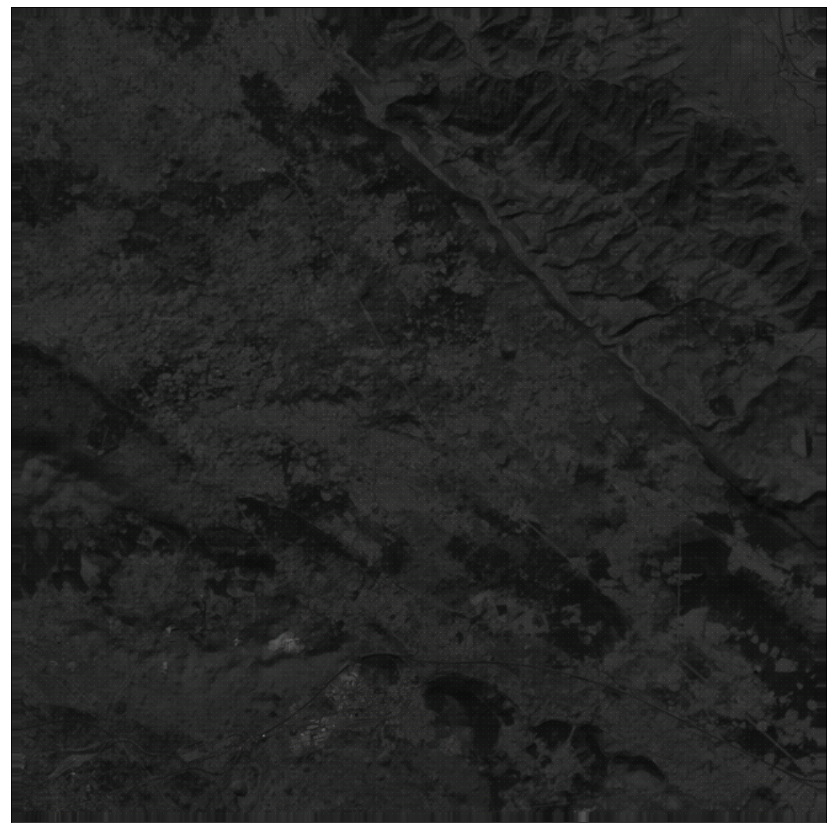

In [10]:
from skimage import color

gachi = np.zeros((1532, 1532))
#Implementing sliding window and prediction approach
def sliding_window(image, stepSize, windowSize):
    i = 0
    for y in range(0, image.shape[1], stepSize):
        for x in range(0, image.shape[2], stepSize):            
            start_time = time.time()
            ROI = image[0:12, y:y + windowSize, x:x + windowSize]
            i  += 1
            print(i)
            prediction = last_model.predict(ROI)

            avg = np.empty(11)
            for q in range(11):
                for j in range(12):
                    avg2 = np.empty(12)
                    month = prediction[j]
                    element = month[q]
                    avg2[j] = element
                avg[q] = np.average(avg2)

            result = np.where(avg == np.amax(avg))
            if i == 12:
                print(prediction)
                print(result[0])
            if x < 1501 and y < 1501:
                gachi[y+16,x+16] = result[0]
            print("--- %s sec ---" % (time.time() - start_time))

#Implementing plotting landcover approach
def plotClass(a):
    #Creating color map for all the 11 classes in asc order[0,1,2,...]
    listofColors = ['black', 'darkorange', 'lime','greenyellow','orange','blue','aqua','aquamarine','fuchsia','red','white']
    a = color.label2rgb(a, image = labla, colors = listofColors) #image = background for landcover
    plt.figure(figsize=(15, 15))
    plt.xticks([]), plt.yticks([])
    plt.imshow(a)
    plt.show()

#Executing sliding window and prediction approach, with 10px step it should approxm take (1500/10)^2 = 22500 steps
sliding_window(ba2, 10, 33)
np.save('gachi', gachi)
labla = color.rgb2gray(picpuc[3])
#Executing plotting approach
plotClass(gachi)